In [ ]:
'''
#mean reversion and momentum properties are exhibited by a single time series.
#a long term memory drives the long term trend- that is there is high levels of autocorrelation in asset values (momentum)
    -some form of moving average or ARIMA model can fit this process.
#we use detrended fluctuation analysis to strip out the temporal fluctuations, which follow a mean reversion process.
#lastly we need to make sure we can 

#Risk management- what happens if we simply set some rules around peaks of asset price (52week) 
    or some momentum indicator (20,2) to stop us jumping in
'''

In [83]:
#test for dollar bars later
#test for dollar bars later
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
import datetime
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
tickers = ['SFRZ4 Comdty']


#last 10 business days of intraday data
df = pd.DataFrame()

for ticker in tickers:
    for i in range(0,2*252):
        #print(i)
        today = datetime.datetime.today()
        date = today - BDay(i)
        #print(date)


        #lets do outright futures, swap spreads and future spreads
        fut = blp.bdib(ticker=ticker, dt= date , ref='CME', interval=1)
        if fut.columns.nlevels > 1:
            fut.columns = fut.columns.droplevel(0)
        df = df.append(fut)

    df['ticker']= ticker
    df['date']=df.index.strftime("%m/%d/%Y")
    df['time']= df.index.strftime("%H:%M:%S")
    df.sort_index(ascending=True, inplace = True)
    df.index = df.index.tz_localize(None)

    
trades = df[['close','volume']].copy()
trades.reset_index(inplace= True)
trades['index']=pd.to_numeric(trades['index'])#trades['index'].astype(str)

def calculateMaxDD(cumret):
# =============================================================================
# calculation of maximum drawdown and maximum drawdown duration based on
# cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
# i is the index of the day with maxDD.
# =============================================================================
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
             
    maxDD, i=np.min(drawdown), np.argmin(drawdown) # drawdown < 0 always
    maxDDD=np.max(drawdownduration)
    return maxDD, maxDDD, i

#generate volume bars we only fill a new bar if a set number of futures are traded. 
#This will remove a lot of the asia session futures with low liquitiy
def generate_volumebars(trades, frequency=10):
    times = trades[:,0]
    prices = trades[:,1]
    volumes = trades[:,2]
    ans = np.zeros(shape=(len(prices), 6))
    candle_counter = 0
    vol = 0
    lasti = 0
    for i in range(len(prices)):
        vol += volumes[i]
        if vol >= frequency:
            #print(times[i] )
            #print(ans[candle_counter][0])
            ans[candle_counter][0] = times[i]             # time
            ans[candle_counter][1] = prices[lasti]                     # open
            ans[candle_counter][2] = np.max(prices[lasti:i+1])         # high
            ans[candle_counter][3] = np.min(prices[lasti:i+1])         # low
            ans[candle_counter][4] = prices[i]                         # close
            ans[candle_counter][5] = np.sum(volumes[lasti:i+1])        # volume
            candle_counter += 1
            lasti = i+1
            vol = 0
    return ans[:candle_counter]

#determine trading volume threshold
#lets just use average for now.
#going fwd we can do a 20 day moving average sampled about 50 times a day
threshold = round(trades['volume'].mean(),0)

volume_trades =generate_volumebars(trades.to_numpy(), frequency =threshold)

volume_trades = pd.DataFrame(volume_trades, columns =['index','open','high','low','close','volume'])
volume_trades.set_index('index', inplace = True)

trades.set_index('index', inplace = True)
#convert back to datetime
volume_trades.index = pd.to_datetime(volume_trades.index.astype(np.int64), format ='%Y-%m-%d %H:%M:%S')
trades.index = pd.to_datetime(trades.index, format ='%Y-%m-%d %H:%M:%S')


<AxesSubplot:xlabel='index'>

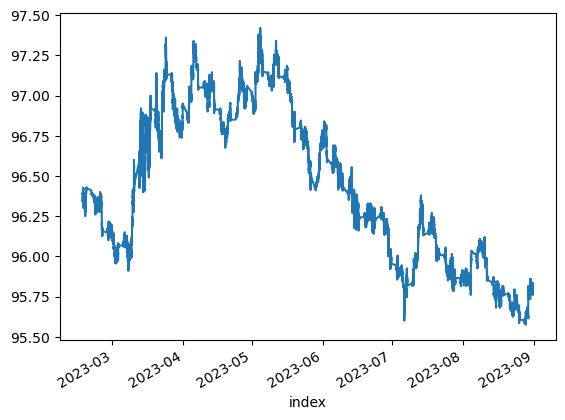

In [82]:

volume_trades['close'].plot()#.set_index('index', inplace = True)
#trades['close'].plot()
#ewm_lag_short.plot()
#ewm_lag_long.plot()

In [ ]:
#look at the detrended mean reversions speed.

In [ ]:
#Mean reversion detrend strategy
# we want different lookback periods
# different lag periods on the detrended time series
#holding period, average time to cross mid point, we can optimize later.

#analytics - # crosses through mid, max and # drawdown, convexity & kurtosis.
#for later... stop loss maybe using some form of 


#For any futures product 
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
trade_long_list = []
trade_short_list =[]
mean_return_list = []
#results lists
results_lookback_list = []
results_hold_list = []
results_bound_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
bound_entry_list =[]
lookback_list = []
holdtime_list = []
long_time_list = []
short_time_list = []
long_avg_return_list = []
short_avg_return_list = []
mean_return_list = []
hitrate_list =[]
long_hitrate_list = []
short_hitrate_list = []

winners_avg_return_list = []
losers_avg_returns_list = []
hitrate_bro_list =[]
mean_return_bro_list =[]
sharpe_bro_list =[]
apr_bro_list = []
results_lag_list =[]
#brokerage
#assume 0.5bp slippage
brokerage = 0.005
#average ticks per day

average_daily_ticks = round(volume_trades[['close']].groupby([volume_trades.index.date]).count().mean(),0)
average_daily_ticks = 300
#lookback for mean for detrending
for p in range(30,10*60+1,30): #maybe reduce to 1 hour blocks
    lookback_list.append(p)    

#lag on the mean, for signal
for p in range(30,360,30): #maybe reduce to 1 hour blocks
    lag_list.append(p)    
#lookback_list =[24*60*10]    
#lag_list = [60]
for p in range(80,100,5):
    #1.0005
    bound_entry_list.append(p/100)
bound_entry_list =[0.4,0.45,0.5,0.55, 0.6, 0.7, 0.8, 0.9]    
#different holdtimes
for p in range(180,480,60):
    holdtime_list.append(p)    

    
#holdtime_list=[60]
    
#try first for holdtime

for lookback in lookback_list:
    #generate the mean reversion zscore signal
    start_time = time.time()
    print('lookback '+str(lookback))
    df = volume_trades[['close']].copy()
    df['z_close'] = (df['close'] - df['close'].rolling(window=lookback).mean()) / df['close'].rolling(window=lookback).std() # one hour MA
    #drop times outside of est 7am - 5pm
    df=df.between_time('7:00', '17:00') 
    ##Apply lags
    for lag in lag_list:
        #print('lag '+str(lag))
        df['zp_data'] = df['z_close'] - df['z_close'].shift(lag)
        df.dropna(inplace = True)
        #object= StandardScaler()
        scaler = MaxAbsScaler()
        standard = scaler.fit_transform(df[['zp_data']])
        df['zp_data_standard'] = standard

        for bound in bound_entry_list:
            #print("bound "+str(bound))

        #create table of longs and shorts
        #***Incomplete****set conditions where we only initiate positions during our time zone 7am - (5pm- holdtime)
            longs= df['zp_data_standard'] < -bound
            shorts= df['zp_data_standard'] > bound

        
            for holdtime in holdtime_list:
                #print("holdtime "+str(holdtime))
                pos=np.zeros(df[['close']].shape)
                pos_long = np.zeros(df[['close']].shape)
                pos_short = np.zeros(df[['close']].shape)
                for h in range(holdtime-1):
                    # signal can double down but we modify for this later. This is good data for strength of the signal
                    #print("holdtime_loop_"+str(h))
                    long_lag=longs.copy().shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 
                    #print("long_lag")
                    #print(long_lag.tail(50))
                    short_lag=shorts.copy().shift(h).fillna(False)
                    ##set condition to take profit once we hit the mean on an open position.
                    #- this involves zeroing out pos where [-1,-1] indicator returns to 0 
                    #print(df['zp_data_standard'][long_lag])
                    #if df['zp_data_standard'][]   
                    pos[long_lag]=pos[long_lag]+1
                    pos[short_lag]=pos[short_lag]-1       
                    pos_long[long_lag] = pos_long[long_lag]+1
                    pos_short[short_lag] = pos_short[short_lag]-1       
                    
                pos=pd.DataFrame(pos, index = longs.index)
                pos_long = pd.DataFrame(pos_long, index = longs.index)
                pos_long['entry_pos'] = longs
                pos_long['entry_pos'] = pos_long['entry_pos'].apply(lambda x: 1 if x == True else 0)
                pos_short = pd.DataFrame(pos_short, index = longs.index)
                pos_short['entry_pos'] = shorts
                pos_short['entry_pos'] = pos_short['entry_pos'].apply(lambda x: -1 if x == True else 0)
                pos[pos[0]>1] = 1
                pos[pos[0]<-1] = -1

                pos_long['exit'] = df['zp_data_standard'].apply(lambda x: -1 if x > 0 else 0)
                pos_long[0] = pos_long[0].apply(lambda x: 1 if x >0 else 0)
                pos_long[0][pos_long[0]>0]=1


                #shorts close out where the signal turns negative 
                pos_short['exit'] = df['zp_data_standard'].apply(lambda x: 1 if x < 0 else 0)
                pos_short[0] = pos_short[0].apply(lambda x: -1 if x <0 else 0)
                pos_short[0][pos_short[0]<0]=-1
                #target hit/reversion back to the mean- we create a new position column to close out before the holdtime is met
                #longs
                pos_with_tp_list = [0]
                pos_long_reset_idx = pos_long.reset_index()

                pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
                                         if ((row[0]==1) & ((row["exit"]==-1 )|(pos_with_tp_list[row.name-1] == -1)))
                                         else pos_with_tp_list.extend([0]), axis = 1 )


                del pos_with_tp_list[0]
                #pos_long_test = pos_long.copy()
                pos_long['pos_with_tp']=pos_with_tp_list
                pos_long['pos_with_tp']=pos_long['pos_with_tp'].copy() +pos_long[0]

                #shorts
                pos_with_tp_list = [0]
                pos_short_reset_idx = pos_short.reset_index()
                #pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
                #                         if (row[0]==1 & (pos_with_tp_list[row.name-1] == -1 | row['exit'] == -1)) 
                #                         else pos_with_tp_list.extend([0]), axis = 1 )
                pos_short_reset_idx.apply(lambda row: pos_with_tp_list.extend([1]) 
                                         if ((row[0]==-1) & ((row["exit"]==1 )|(pos_with_tp_list[row.name-1] == 1)))
                                         else pos_with_tp_list.extend([0]), axis = 1 )

                #pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
                #                         if (row[0]==1 &(row["exit"]==-1))
                #                         else pos_with_tp_list.extend([0]), axis = 1 )
                del pos_with_tp_list[0]
                #pos_short_test = pos_short.copy()
                pos_short['pos_with_tp']=pos_with_tp_list
                pos_short['pos_with_tp']=pos_short['pos_with_tp'].copy() +pos_short[0]
                pos_original = pos[0].copy()
                pos[0]=(pos_long[['pos_with_tp']]+pos_short[['pos_with_tp']])

                #performance analytics
                #count long and short trades
                pos_long['trade_grouping']=pos_long['pos_with_tp'].diff().ne(0).cumsum()
                number_longs= len(pos_long['trade_grouping'][pos_long['pos_with_tp']!=0].unique())
                pos_short['trade_grouping']=pos_short['pos_with_tp'].diff().ne(0).cumsum()
                number_shorts=len(pos_short['trade_grouping'][pos_short['pos_with_tp']!=0].unique())

                #average ticks/time per trade
                longs_avg_ticks = round(pos_long[['trade_grouping','pos_with_tp']][pos_long['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()[0],0)
                shorts_avg_ticks = round(pos_short[['trade_grouping','pos_with_tp']][pos_short['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()[0],0)
                long_time_list.extend([longs_avg_ticks])
                short_time_list.extend([shorts_avg_ticks])

                #return per trade (absolute bps)
                #longs and shorts

                long_pnl_df = pd.merge(pos_long.shift(),df[["close"]].diff(), how = 'left', left_index = True, right_index = True)
                long_pnl_df['abs_return'] = long_pnl_df['pos_with_tp']*long_pnl_df['close']
                short_pnl_df = pd.merge(pos_short.shift(),df[["close"]].diff(), how = 'left', left_index = True, right_index = True)
                short_pnl_df['abs_return'] = short_pnl_df['pos_with_tp']*short_pnl_df['close']

                avg_long_pnl = long_pnl_df[['trade_grouping','abs_return']][long_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()
                avg_short_pnl = short_pnl_df[['trade_grouping','abs_return']][short_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()
                avg_pnl_df= (long_pnl_df[['trade_grouping','abs_return']][long_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()
                             .append(short_pnl_df[['trade_grouping','abs_return']][short_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()))
                avg_pnl_bro_df = avg_pnl_df - brokerage
                long_avg_return_list.extend([avg_long_pnl][0])
                short_avg_return_list.extend([avg_short_pnl][0])
                mean_return_list.extend([avg_pnl_df.mean()[0]])
                hitrate_list.extend([len(avg_pnl_df[avg_pnl_df['abs_return']>0])/len(avg_pnl_df)])

                long_hitrate_df = long_pnl_df[['trade_grouping','abs_return']][long_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()
                short_hitrate_df = short_pnl_df[['trade_grouping','abs_return']][short_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()

                if len(long_hitrate_df)>0:
                    long_hitrate_list.extend([len(long_hitrate_df[long_hitrate_df['abs_return']>0])/len(long_hitrate_df)])
                else:
                    long_hitrate_list.extend([0])
                if len(short_hitrate_df)>0:
                    short_hitrate_list.extend([len(short_hitrate_df[short_hitrate_df['abs_return']>0])/len(short_hitrate_df)])
                else:
                    short_hitrate_list.extend([0])
                #after brokerage stats
                hitrate_bro_list.extend([len(avg_pnl_bro_df[avg_pnl_bro_df['abs_return']>0])/len(avg_pnl_bro_df)])
                mean_return_bro_list.extend([avg_pnl_bro_df.mean()[0]])

            #after bro sharpe
            #we need to merge the long and short exits from the prior dataframes 

                #PNL and sharpe
                pnl=np.sum((pos.shift().values)*(df[["close"]].pct_change()), axis=1) # daily P&L of the strategy
                pnl_long =np.sum((pos_long[[0]].shift().values)*(df[["close"]].pct_change()), axis=1)
                pnl_short = np.sum((pos_short[[0]].shift().values)*(df[["close"]].pct_change()), axis=1)
                ret=pnl#/np.sum(np.abs(pos.shift()), axis=1)
                #print(np.mean(ret))
                #print(np.std(ret))
                cumret=(np.cumprod(1+ret)-1)
                cumret_long=(np.cumprod(1+pnl_long)-1)
                cumret_short=(np.cumprod(1+pnl_short)-1)
                #print("---returns data %s seconds ---" % (time.time() - start_time))
                #start_time = time.time()
                sharpe = np.sqrt(252*average_daily_ticks)*np.mean(ret)/np.std(ret)
                #print("---sharpe data %s seconds ---" % (time.time() - start_time))
                #start_time = time.time()
                print('APR=%f Sharpe=%f' % (np.prod(1+ret)**((252*average_daily_ticks)/len(ret))-1, np.sqrt(252*average_daily_ticks)*np.mean(ret)/np.std(ret)))
                pos1 =pos.copy()
                pos1['trade_grouping'] = pos1[0].diff().ne(0).cumsum()
                pos1['trade_grouping_diff'] =pos1['trade_grouping'].diff(1).shift(1)
                pos1['trade_grouping_diff'] = pos1['trade_grouping_diff'].fillna(0)
                pos1['trade_grouping_diff'] = pos1['trade_grouping_diff']*pos1[0] #add spread to start of trade if long and vice versa
                pnl_sharpe = pd.merge(df, pos1, how = 'left', left_index = True, right_index = True)
                pnl_sharpe['close_brokerage']=pnl_sharpe['close']+pnl_sharpe['trade_grouping_diff']*(brokerage)
                pnl_sharpe = pnl_sharpe[0].shift()*pnl_sharpe['close_brokerage'].shift().pct_change()
                sharpe_bro = np.sqrt(252*average_daily_ticks)*np.mean(pnl_sharpe)/np.std(pnl_sharpe)

                sharpe_bro_list.extend([sharpe_bro])
                maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
                #print("---maxdd data %s seconds ---" % (time.time() - start_time))
                #print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
                results_lookback_list.append(lookback)
                results_hold_list.append(holdtime)
                results_lag_list.append(lag)
                results_bound_trigger_list.append(bound)
                apr_list.append(np.prod(1+ret)**((252*average_daily_ticks)/len(ret))-1)
                sharpe_list.append(sharpe)
                dd_list.append(maxDD)
                dd_time_list.append(maxDDD)
                trade_long_list.append(number_longs)
                trade_short_list.append(number_shorts)

            print("---Runtime total %s mins ---" % ((time.time() - start_time)/60))


df_results['lookback'] = results_lookback_list
df_results['indicator_lag'] = np.tile(lag_list, len(df_results) // len(lag_list) + 1)[:len(df_results)]  
df_results['holdtime_mins'] = results_hold_list
df_results['trigger_bound'] = results_bound_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['trades_no'] = df_results['long_trades_no'] + df_results['short_trades_no']
df_results['long_avg_ticks'] = long_time_list
df_results['short_avg_ticks'] = short_time_list
df_results['long_avg_abs_pnl'] = long_avg_return_list
df_results['short_avg_abs_pnl'] = short_avg_return_list
df_results['long_hitrate'] = long_hitrate_list
df_results['short_hitrate'] = short_hitrate_list
df_results['mean_return_bps'] = mean_return_list
df_results['hitrate'] = hitrate_list
df_results['hitrate_after_bro']  = hitrate_bro_list
df_results['sharpe_after_bro'] = sharpe_bro_list


lookback 30
APR=0.005341 Sharpe=1.279812
APR=-0.000256 Sharpe=-0.078021
APR=-0.000585 Sharpe=-0.672987
APR=-0.000695 Sharpe=-1.014959
APR=-0.000695 Sharpe=-1.014959
---Runtime total 0.2744481325149536 mins ---
APR=0.006002 Sharpe=1.179676
APR=0.004369 Sharpe=1.239389
APR=0.001263 Sharpe=1.013674
APR=0.001149 Sharpe=1.197098
APR=-0.000695 Sharpe=-1.014959
---Runtime total 0.5439918398857116 mins ---
APR=0.019812 Sharpe=2.672951
APR=0.012200 Sharpe=2.648698
APR=0.002793 Sharpe=1.099522
APR=0.000584 Sharpe=0.419327
APR=0.000580 Sharpe=1.492277
---Runtime total 0.8100416978200277 mins ---
APR=0.025733 Sharpe=3.481371
APR=0.024659 Sharpe=3.941893
APR=0.009431 Sharpe=2.600792
APR=0.005574 Sharpe=1.864903
APR=0.001865 Sharpe=1.027516
---Runtime total 1.078932245572408 mins ---
APR=0.004158 Sharpe=0.629597
APR=0.005685 Sharpe=0.996773
APR=0.000123 Sharpe=0.026966
APR=-0.001149 Sharpe=-0.251880
APR=0.000107 Sharpe=0.027617
---Runtime total 1.3500697056452433 mins ---
APR=0.005113 Sharpe=0.98213

APR=0.000596 Sharpe=0.283485
---Runtime total 11.632867173353832 mins ---
APR=0.020029 Sharpe=2.748107
APR=0.015728 Sharpe=2.771752
APR=0.011124 Sharpe=2.214599
APR=0.005094 Sharpe=1.641751
APR=0.001419 Sharpe=0.623741
---Runtime total 11.89507786432902 mins ---
APR=0.015074 Sharpe=2.018123
APR=0.014577 Sharpe=2.220592
APR=0.015185 Sharpe=2.578070
APR=0.006273 Sharpe=1.242647
APR=0.000502 Sharpe=0.110437
---Runtime total 12.157562569777172 mins ---
APR=0.008737 Sharpe=1.819344
APR=0.008258 Sharpe=1.759719
APR=0.007778 Sharpe=1.878734
APR=0.006714 Sharpe=1.742690
APR=0.005647 Sharpe=1.573476
---Runtime total 12.421232084433237 mins ---
APR=0.005770 Sharpe=2.306599
APR=0.006591 Sharpe=2.751632
APR=0.006591 Sharpe=2.751632
APR=0.006591 Sharpe=2.751632
APR=0.006591 Sharpe=2.751632
---Runtime total 12.684663919607798 mins ---
APR=0.000336 Sharpe=0.173885
APR=0.000336 Sharpe=0.173885
APR=0.000336 Sharpe=0.173885
APR=0.000336 Sharpe=0.173885
APR=0.000336 Sharpe=0.173885
---Runtime total 12.94

APR=0.012746 Sharpe=2.648487
APR=0.012623 Sharpe=2.672195
APR=0.011880 Sharpe=2.536470
APR=0.012620 Sharpe=2.726929
---Runtime total 22.888652801513672 mins ---
APR=0.004024 Sharpe=1.970936
APR=0.004024 Sharpe=1.970936
APR=0.004024 Sharpe=1.970936
APR=0.004024 Sharpe=1.970936
APR=0.004024 Sharpe=1.970936
---Runtime total 23.136668809254964 mins ---
APR=0.000001 Sharpe=0.002445
APR=0.000001 Sharpe=0.002445
APR=0.000001 Sharpe=0.002445
APR=0.000001 Sharpe=0.002445
APR=0.000001 Sharpe=0.002445
---Runtime total 23.380546112855274 mins ---
APR=0.004313 Sharpe=1.231018
APR=0.002462 Sharpe=1.343270
APR=0.001845 Sharpe=1.383367
APR=0.002955 Sharpe=2.515975
APR=0.001360 Sharpe=1.637833
---Runtime total 23.632743346691132 mins ---
APR=0.005649 Sharpe=1.240463
APR=0.001705 Sharpe=0.501549
APR=-0.003439 Sharpe=-1.556084
APR=-0.002817 Sharpe=-1.712419
APR=0.001235 Sharpe=1.643215
---Runtime total 23.882888583342233 mins ---
APR=0.007720 Sharpe=1.332670
APR=0.007426 Sharpe=1.700276
APR=-0.003676 Sha

APR=0.000926 Sharpe=0.954260
---Runtime total 8.551634669303894 mins ---
APR=0.024558 Sharpe=2.946581
APR=0.013030 Sharpe=1.868998
APR=0.011865 Sharpe=2.171450
APR=0.006222 Sharpe=1.419430
APR=0.002461 Sharpe=0.676338
---Runtime total 8.823400143782298 mins ---
APR=0.020923 Sharpe=2.227459
APR=0.014539 Sharpe=1.824918
APR=0.010178 Sharpe=1.464213
APR=0.011391 Sharpe=2.108309
APR=0.004195 Sharpe=0.868385
---Runtime total 9.093300437927246 mins ---
APR=0.008257 Sharpe=0.915686
APR=0.007105 Sharpe=0.852040
APR=-0.002487 Sharpe=-0.308579
APR=-0.000160 Sharpe=-0.021591
APR=-0.001434 Sharpe=-0.230732
---Runtime total 9.368470986684164 mins ---
APR=0.009092 Sharpe=1.281102
APR=0.009223 Sharpe=1.369037
APR=0.009468 Sharpe=1.459909
APR=0.003812 Sharpe=0.662246
APR=0.005110 Sharpe=0.912267
---Runtime total 9.635267309347789 mins ---
APR=0.003807 Sharpe=0.610525
APR=0.004409 Sharpe=0.734354
APR=0.007354 Sharpe=1.261892
APR=0.004056 Sharpe=0.715076
APR=0.004522 Sharpe=0.835450
---Runtime total 9.9

APR=0.004618 Sharpe=0.579391
APR=0.008021 Sharpe=1.027041
APR=0.008991 Sharpe=1.221259
APR=0.009369 Sharpe=1.381182
---Runtime total 19.891457947095237 mins ---
APR=0.002895 Sharpe=0.445196
APR=-0.000236 Sharpe=-0.033129
APR=0.000126 Sharpe=0.022779
APR=0.001930 Sharpe=0.327909
APR=0.004124 Sharpe=0.778419
---Runtime total 20.145482552051543 mins ---
APR=-0.002862 Sharpe=-0.544187
APR=-0.004303 Sharpe=-0.806813
APR=-0.004182 Sharpe=-0.784155
APR=-0.003942 Sharpe=-0.751953
APR=-0.002732 Sharpe=-0.527837
---Runtime total 20.398724738756815 mins ---
APR=-0.002529 Sharpe=-0.795058
APR=-0.003970 Sharpe=-1.197649
APR=-0.003970 Sharpe=-1.197649
APR=-0.003730 Sharpe=-1.177932
APR=-0.003730 Sharpe=-1.177932
---Runtime total 20.659716335932412 mins ---
APR=-0.000235 Sharpe=-0.129401
APR=-0.000235 Sharpe=-0.129401
APR=-0.000235 Sharpe=-0.129401
APR=0.000005 Sharpe=0.004362
APR=0.000005 Sharpe=0.004362
---Runtime total 20.92194607655207 mins ---
APR=0.000124 Sharpe=0.163931
APR=0.000124 Sharpe=0.1

In [94]:
df_results

,lookback,indicator_lag,holdtime_mins,trigger_bound,apr,sharpe,max_dd,max_dd_ticks,max_dd_days,long_trades_no,...,long_avg_ticks,short_avg_ticks,long_avg_abs_pnl,short_avg_abs_pnl,long_hitrate,short_hitrate,mean_return_bps,hitrate,hitrate_after_bro,sharpe_after_bro
0,28800,180,420,0.45,-0.008526,-0.990915,-0.002866,11785.0,8.184028,15,...,92.0,-19.0,-0.009667,0.000312,0.4,0.395833,-0.002063,0.396825,0.15873,-1.373669


In [76]:
df_results['lookback'] = results_lookback_list
df_results['indicator_lag'] = np.tile(lag_list, len(df_results) // len(lag_list) + 1)[:len(df_results)]  
df_results['holdtime_mins'] = results_hold_list
df_results['trigger_bound'] = results_bound_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['long_avg_ticks'] = long_time_list
df_results['short_avg_ticks'] = short_time_list
df_results['long_avg_abs_pnl'] = long_avg_return_list
df_results['short_avg_abs_pnl'] = short_avg_return_list
df_results['long_hitrate'] = long_hitrate_list
df_results['short_hitrate'] = short_hitrate_list
df_results['mean_return_bps'] = mean_return_list
df_results['hitrate'] = hitrate_list
df_results['hitrate_after_bro']  = hitrate_bro_list
df_results['sharpe_after_bro'] = sharpe_bro_list


ValueError: Length of values (74) does not match length of index (73)

In [92]:
lag_list

[180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 180]

<AxesSubplot:xlabel='index'>

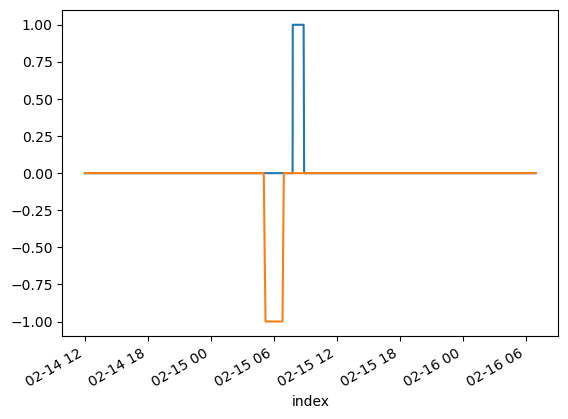

In [65]:
pos_long['pos_with_tp'].head(500).plot()
pos_short['pos_with_tp'].head(500).plot()

In [69]:
#pos_original.tail(10000).plot()
pos[[0]].to_csv('postiion_check.csv')

In [442]:
df_results['lookback'] = results_lookback_list
df_results['indicator_lag'] = np.tile(lag_list, len(df_results) // len(lag_list) + 1)[:len(df_results)]  
df_results['holdtime_mins'] = results_hold_list
df_results['trigger_bound'] = results_bound_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['mean_return'] = mean_return_list
df_results.to_csv('backtest_detrend_meanreversion_intra_sfrz4.csv')


<AxesSubplot:xlabel='index'>

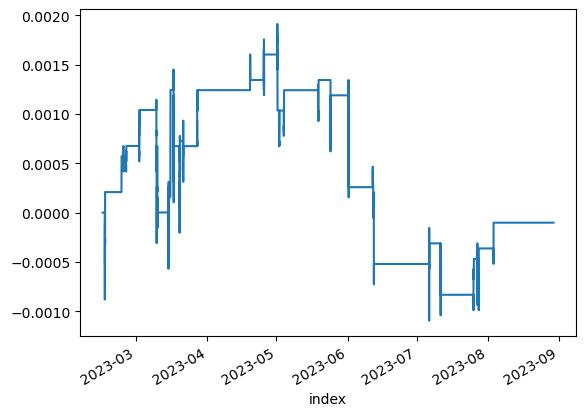

In [19]:
#pos[0].plot()
ret.cumsum().plot()

<AxesSubplot:xlabel='index'>

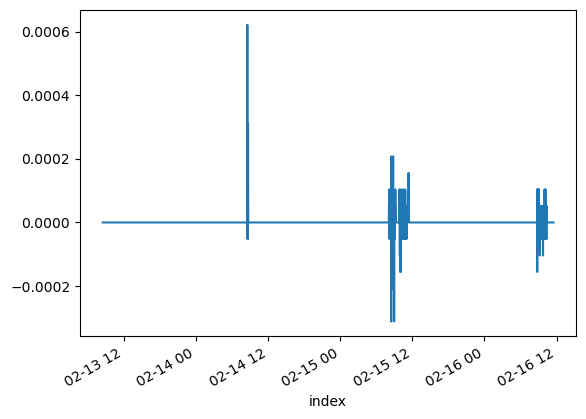

In [439]:
ret.head(1000).plot()

<AxesSubplot:xlabel='index'>

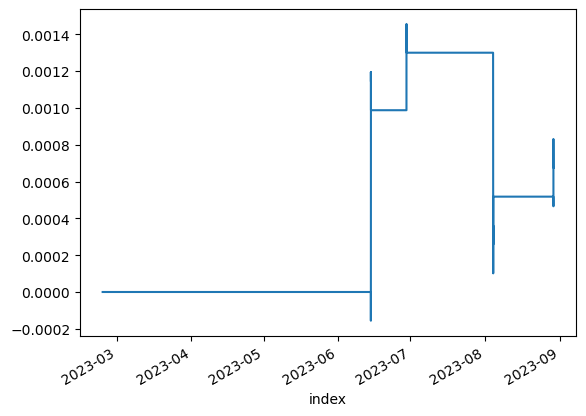

In [11]:
ret.cumsum().plot()

<AxesSubplot:xlabel='index'>

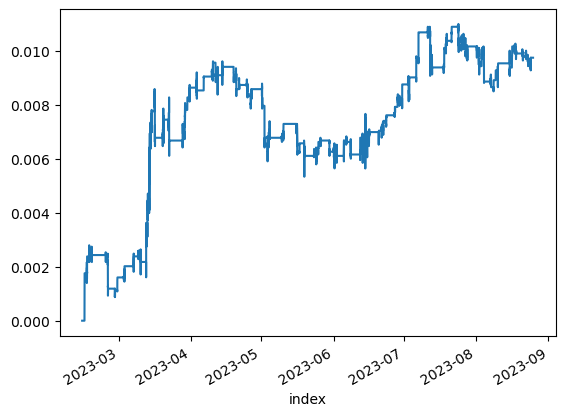

In [433]:
ret.cumsum().plot()

<AxesSubplot:xlabel='index'>

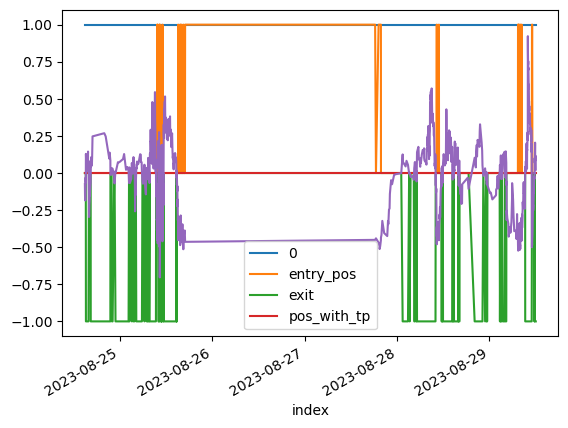

In [20]:
#longs close out where the signal turns positive 
pos_long['exit'] = df['zp_data_standard'].apply(lambda x: -1 if x > 0 else 0)
pos_long[0] = pos_long[0].apply(lambda x: 1 if x >0 else 0)
#shorts close out where the signal turns negative 
pos_short['exit'] = df['zp_data_standard'].apply(lambda x: -1 if x < 0 else 0)
pos_long.tail(1000).plot()#['entry_pos'].apply(lambda x: 1 if x == False else 0)
pos_long[0][pos_long[0]>0]=1
df['zp_data_standard'].tail(1000).plot()

In [423]:
pos[0]=(pos_long[['pos_with_tp']]+pos_short[['pos_with_tp']])

<AxesSubplot:xlabel='index'>

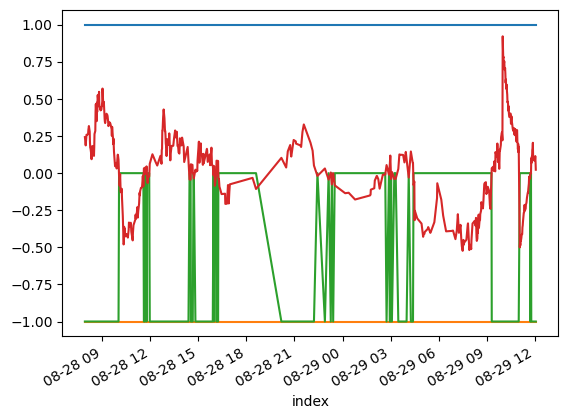

In [21]:
pos_with_tp_list = [0]
pos_with_tp_list_v2 =[0]
pos_long_reset_idx = pos_long.reset_index()
#pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
#                         if (row[0]==1 & (pos_with_tp_list[row.name-1] == -1 | row['exit'] == -1)) 
#                         else pos_with_tp_list.extend([0]), axis = 1 )
pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
                         if (row[0]==1)
                         else pos_with_tp_list.extend([0]), axis = 1 )

#pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
#                         if (row[0]==1 &(row["exit"]==-1))
#                         else pos_with_tp_list.extend([0]), axis = 1 )
del pos_with_tp_list[0]
pos_long_test = pos_long.copy()
pos_long_test['pos_with_tp']=pos_with_tp_list
pos_long_test[0].tail(500).plot()
pos_long_test['pos_with_tp'].tail(500).plot()
pos_long_test['exit'].tail(500).plot()
df['zp_data_standard'].tail(500).plot()

<AxesSubplot:xlabel='index'>

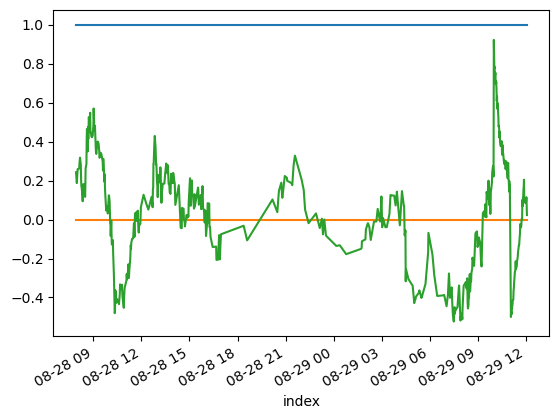

In [22]:
pos_with_tp_list = [0]
pos_with_tp_list_v2 =[0]
pos_long_reset_idx = pos_long.reset_index()
#pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
#                         if (row[0]==1 & (pos_with_tp_list[row.name-1] == -1 | row['exit'] == -1)) 
#                         else pos_with_tp_list.extend([0]), axis = 1 )
pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
                         if ((row[0]==1) & ((row["exit"]==-1 )|(pos_with_tp_list[row.name-1] == -1)))
                         else pos_with_tp_list.extend([0]), axis = 1 )

#pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
#                         if (row[0]==1 &(row["exit"]==-1))
#                         else pos_with_tp_list.extend([0]), axis = 1 )
del pos_with_tp_list[0]
pos_long_test = pos_long.copy()
pos_long_test['pos_with_tp']=pos_with_tp_list
pos_long_test['pos_with_tp']=pos_long_test['pos_with_tp'].copy() +pos_long_test[0]
pos_long_test[0].tail(500).plot()
pos_long_test['pos_with_tp'].tail(500).plot()
df['zp_data_standard'].tail(500).plot()
#pos_long_test['exit'].tail(500).plot()

In [23]:
pos_short_test[0].tail(500).plot()
pos_short_test['pos_with_tp'].tail(500).plot()
df['zp_data_standard'].tail(500).plot()
#pos_short['exit'].tail(500).plot()

NameError: name 'pos_short_test' is not defined

<AxesSubplot:xlabel='trade_grouping'>

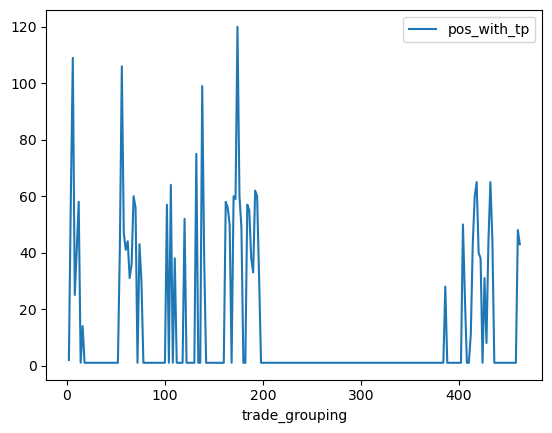

In [429]:
pos_long_test['trade_grouping']=pos_long_test['pos_with_tp'].diff().ne(0).cumsum()
average_tp_time = pos_long_test[['trade_grouping','pos_with_tp']][pos_long_test['pos_with_tp']>0].groupby('trade_grouping').sum()#.median()
#average time to mean revert to target
#pos_long_test['pos_with_tp']#.mean()
average_tp_time.plot()#['pos_with_tp'].median()

In [381]:
pos_long_test[['trade_grouping','pos_with_tp']][pos_long_test['pos_with_tp']>0].groupby('trade_grouping').sum().mean()

pos_with_tp    15.122807
dtype: float64

In [377]:
pos_long_test[['trade_grouping','pos_with_tp']][pos_long_test['pos_with_tp']>0].groupby('trade_grouping').sum()

,pos_with_tp
trade_grouping,
2,2
4,51
6,60
8,109
10,25
...,...
448,1
450,1
452,48


In [356]:
merged_df = pd.merge(df, pos_long_test,how = 'left', left_index = True, right_index = True)


In [359]:
merged_df.to_csv('merged_tp_df.csv')

In [300]:
pos_long_reset_idx.apply(lambda row: pos_with_tp_list_v2.extend([-1]) 
                         if (row[0]==1 & (pos_with_tp_list_v2[row.name-1] == -1 | row['exit'] == -1)) 
                         else pos_with_tp_list_v2.extend([0]), axis = 1 )

TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column

<AxesSubplot:xlabel='index'>

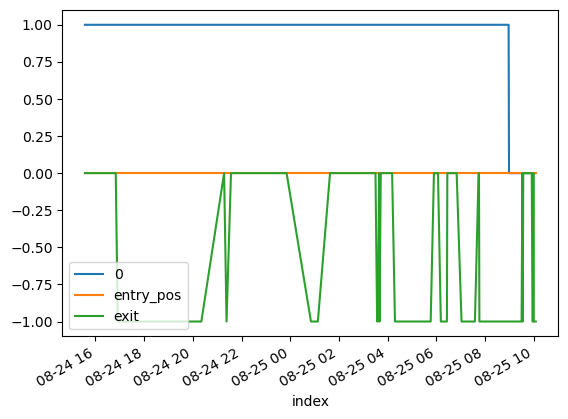

In [280]:
pos_long.tail(200).plot()

<AxesSubplot:xlabel='index'>

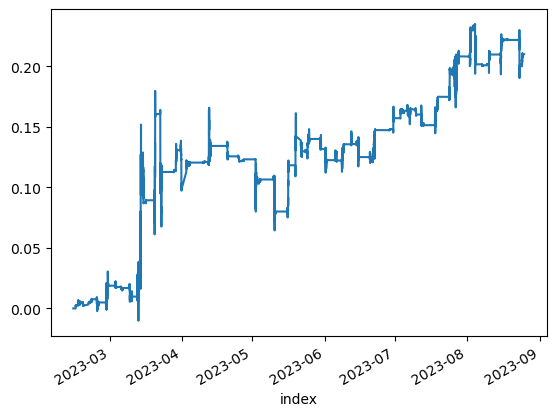

In [208]:
cumret_short.plot()

In [167]:
lookback 300
lag 60
bound 0.4
968
993
APR=0.000085 Sharpe=0.096490
Max DD=-0.010622 Max DDD in days=31201
---maxdd data 2.619002342224121 seconds ---

index
2023-02-10 07:19:00    0.000000
2023-02-10 07:23:00    0.000000
2023-02-10 07:26:00    0.000000
2023-02-10 07:29:00    0.000000
2023-02-10 07:35:00    0.000000
                         ...   
2023-08-24 16:42:00    0.000052
2023-08-24 16:46:00    0.000000
2023-08-24 16:50:00    0.000000
2023-08-24 16:55:00    0.000000
2023-08-24 16:56:00    0.000000
Length: 44597, dtype: float64

In [203]:
pos_long

,longpos
index,
2023-02-10 07:19:00,0.0
2023-02-10 07:23:00,0.0
2023-02-10 07:26:00,0.0
2023-02-10 07:29:00,0.0
2023-02-10 07:35:00,0.0
...,...
2023-08-24 16:42:00,1.0
2023-08-24 16:46:00,1.0
2023-08-24 16:50:00,1.0


In [201]:
pos_df_merge#[['longpos']]

,close,z_close,zp_data,zp_data_standard,0,longpos,shortpos,pnl
index,,,,,,,,
2023-02-10 07:19:00,96.620,-1.326927,-0.284559,-0.041966,0.0,0.0,0.0,0.000000
2023-02-10 07:23:00,96.625,-1.204583,-0.481843,-0.071062,0.0,0.0,0.0,0.000000
2023-02-10 07:26:00,96.625,-1.201054,-0.170053,-0.025079,0.0,0.0,0.0,0.000000
2023-02-10 07:29:00,96.615,-1.434212,-0.723814,-0.106747,0.0,0.0,0.0,0.000000
2023-02-10 07:35:00,96.630,-1.069866,-0.469620,-0.069259,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
2023-08-24 16:42:00,95.675,-1.888568,-0.676324,-0.099743,-1.0,1.0,-1.0,0.000052
2023-08-24 16:46:00,95.675,-1.871043,-0.665529,-0.098151,-1.0,1.0,-1.0,0.000000
2023-08-24 16:50:00,95.675,-1.853867,-0.375712,-0.055410,-1.0,1.0,-1.0,0.000000


<AxesSubplot:xlabel='index'>

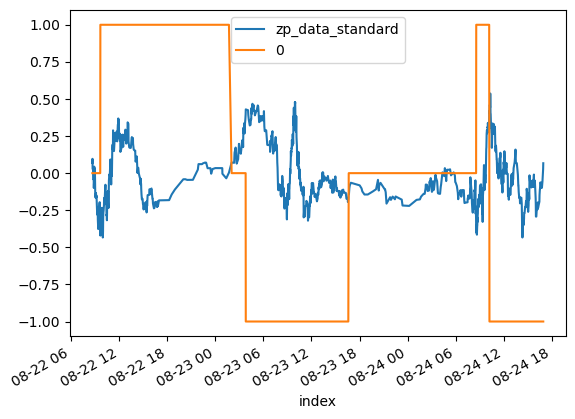

In [195]:

pos_long.rename(columns={0: "longpos"}, inplace = True)
pos_short.rename(columns={0: "shortpos"}, inplace = True)
pos_long[pos_long["longpos"]>0] = 1
pos_short[pos_short['shortpos']<0] = -1
pos_df_merge = pd.merge(df,pos, how = 'left', left_index = True, right_index = True)
pos_df_merge = pd.merge(pos_df_merge,pos_long, how = 'left', left_index = True, right_index = True)
pos_df_merge = pd.merge(pos_df_merge,pos_short, how = 'left', left_index = True, right_index = True)
pos_df_merge['pnl']= pnl
pos_df_merge[['zp_data_standard',0]].tail(1000).plot()


<AxesSubplot:xlabel='index'>

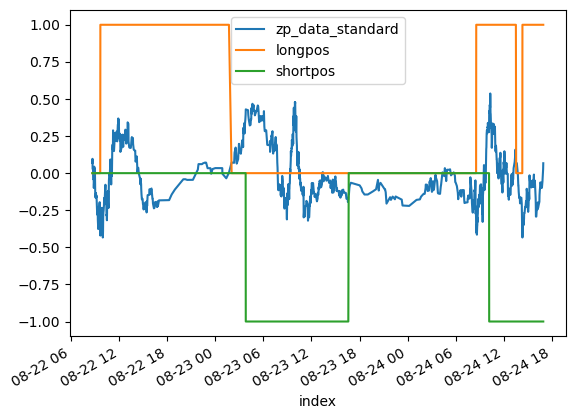

In [196]:
pos_df_merge[['zp_data_standard',"longpos","shortpos"]].tail(1000).plot()

In [170]:
pos_df_merge.to_csv('pnl_pos_check.csv')

In [ ]:
            print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
            results_lookback_list.append(lookback)
            results_hold_list.append(holdtime)
            results_bound_trigger_list.append(bound)
            apr_list.append(np.prod(1+ret)**(252/len(ret))-1)
            sharpe_list.append(sharpe)
            dd_list.append(maxDD)
            dd_time_list.append(maxDDD)
            trade_long_list.append(len(pos[long_lag]>0))
            trade_short_list.append(len(pos[short_lag]>0))
            mean_return_list.append(np.mean(ret))

In [141]:
results_hold_list

[300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300

In [136]:


df_results['NewCol'] #= np.tile(lag_list, len(df_results) // len(lag_list) + 1)[:len(df_results)]  


0       30
1       60
2       90
3      120
4      150
      ... 
635    120
636    150
637    180
638    210
639    240
Name: NewCol, Length: 640, dtype: int32

In [139]:
df_results['lookback'] = results_lookback_list
df_results['indicator_lag'] = np.tile(lag_list, len(df_results) // len(lag_list) + 1)[:len(df_results)]  
df_results['holdtime_mins'] = results_hold_list
df_results['trigger_bound'] = results_bound_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['mean_return'] = mean_return_list
df_results.to_csv('backtest_detrend_meanreversion_intra_v2.csv')

In [46]:
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
trade_long_list = []
trade_short_list =[]
mean_return_list = []
#results lists
results_lookback_list = []
results_hold_list = []
results_zscore_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
bound_entry_list =[]
lookback_list = []
holdtime_list = []
lag_list = []

#lookback for mean for detrending
for p in range(30,10*60+1,30): #maybe reduce to 1 hour blocks
    lookback_list.append(p)    
lookback_list =[24*60*10]

#lag on the mean, for signal
for p in range(30,241,30): #maybe reduce to 1 hour blocks
    lag_list.append(p)    
#lookback_list =[24*60*10]    

for p in range(80,100,5):
    #1.0005
    bound_entry_list.append(p/100)
    
#different holdtimes
for p in range(30,60*5+1,30):
    holdtime_list.append(p)    

    
    
#holdtime_list=[60]
    
#try first for holdtime

for lookback in lookback_list:
    #generate the mean reversion zscore signal
    start_time = time.time()
    print(lookback)
    df = volume_trades[['close']].copy()
    df['z_close'] = (df['close'] - df['close'].rolling(window=lookback).mean()) / df['close'].rolling(window=lookback).std() # one hour MA
    #apply lags
    
    for lag in lag_list:
        df['zp_data'] = df['z_close'] - df['z_close'].shift(lag)
        df.dropna(inplace = True)
        standard = preprocessing.scale(df['zp_data'].dropna())
        zp_data_std =df['zp_data'].std() 
        df['zp_data_standard'] = standard
df

14400


,close,z_close,zp_data,zp_data_standard
index,,,,
2023-04-04 13:36:00,95.885,0.808574,0.267143,1.130602
2023-04-04 13:41:00,95.890,0.817217,0.302180,1.271259
2023-04-04 13:45:00,95.900,0.834611,0.328419,1.376595
2023-04-04 13:50:00,95.890,0.816996,0.310876,1.306167
2023-04-04 13:52:00,95.885,0.808135,0.293313,1.235661
...,...,...,...,...
2023-08-24 12:53:00,94.560,-1.132527,-0.278065,-1.058135
2023-08-24 12:54:00,94.560,-1.132537,-0.278170,-1.058554
2023-08-24 12:58:00,94.565,-1.095352,-0.241078,-0.909649


14400
0.8417306004248089
[0.98422014]
-0.006366422732473665
0.20073676172315927


,close,z_close,zp_data,zp_data_standard
index,,,,
2023-08-24 15:59:00,95.685,-1.534495,-0.172125,-0.201262
2023-08-24 16:00:00,95.685,-1.534282,-0.202776,-0.237102
2023-08-24 16:01:00,95.685,-1.534069,-0.264103,-0.308811
2023-08-24 16:04:00,95.685,-1.533853,-0.264052,-0.308751
2023-08-24 16:07:00,95.685,-1.533641,-0.233320,-0.272817
2023-08-24 16:11:00,95.680,-1.564118,-0.233283,-0.272774
2023-08-24 16:12:00,95.680,-1.563901,-0.202559,-0.236849
2023-08-24 16:13:00,95.680,-1.563685,-0.202527,-0.236811
2023-08-24 16:14:00,95.675,-1.594158,-0.233187,-0.272661


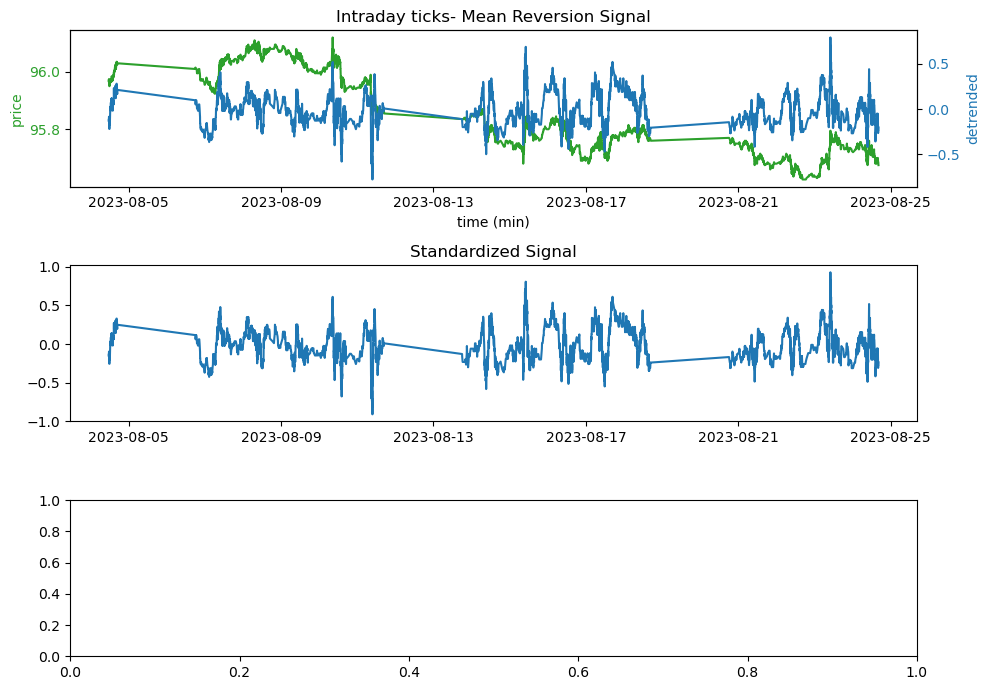

In [114]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
for lookback in lookback_list:
    #generate the mean reversion zscore signal
    start_time = time.time()
    print(lookback)
    df = volume_trades[['close']].copy()
    df['z_close'] = (df['close'] - df['close'].rolling(window=lookback).mean()) / df['close'].rolling(window=lookback).std() # one hour MA
    #apply lags
    
    for lag in lag_list:
        df['zp_data'] = df['z_close'] - df['z_close'].shift(lag)
        df.dropna(inplace = True)
        #object= StandardScaler()
        scaler = MaxAbsScaler()
        standard = scaler.fit_transform(df[['zp_data']])
        print(max(df['zp_data']))
        print(max(standard))
        #zp_data_std =df['zp_data'].std() 
        df['zp_data_standard'] = standard
        print(df['zp_data_standard'].mean())
        print(df['zp_data_standard'].std())

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(311)   #first is number of rows, second is number of columns
fig.add_subplot(312)   
fig.add_subplot(313)   
# create all axes we need
ax0 = plt.subplot(311) #first is number of rows, second is number of columns
ax1 = ax0.twinx()
ax2 = plt.subplot(312)
#ax3 = ax2.twinx()
ax1.set_title('Intraday ticks- Mean Reversion Signal')
ax2.set_title('Standardized Signal')
#signal plot
color = 'tab:green'
ax0.set_xlabel('time (min)')
ax0.set_ylabel('price', color=color)
ax0.plot(df['close'].tail(5000).index, df['close'].tail(5000), color=color)
ax0.tick_params(axis='y', labelcolor=color)

ax4 = plt.subplot(313)
#price plot
color = 'tab:blue'
ax1.set_ylabel('detrended', color=color)  # we already handled the x-label with ax1
ax1.plot(df['zp_data'].tail(5000).index, df['zp_data'].tail(5000), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = plt.subplot(312)
ax2.plot(df['zp_data_standard'].tail(5000).index, df['zp_data_standard'].tail(5000), color=color)
#signal plot
#ax2.plot(pos.index, pos[0], color=color)
#ax2.set_xlabel('time (min)')
#ax2.set_ylabel('positions triggered')
# share the secondary axes
#ax3.get_shared_x_axes().join(ax1, ax3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
df.tail(10)

<AxesSubplot:xlabel='index'>

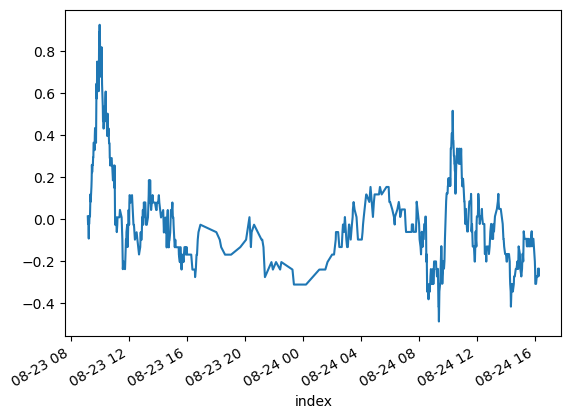

In [112]:
df['zp_data_standard'].tail(60*10).plot()

In [ ]:
df['zp_data'].plot()

<AxesSubplot:xlabel='index'>

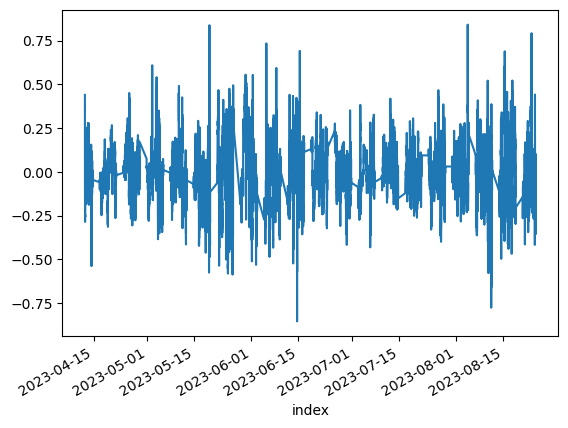

In [109]:
df['zp_data'].plot()

In [68]:
zp_data_std

0.24910166411553447

<AxesSubplot:xlabel='index'>

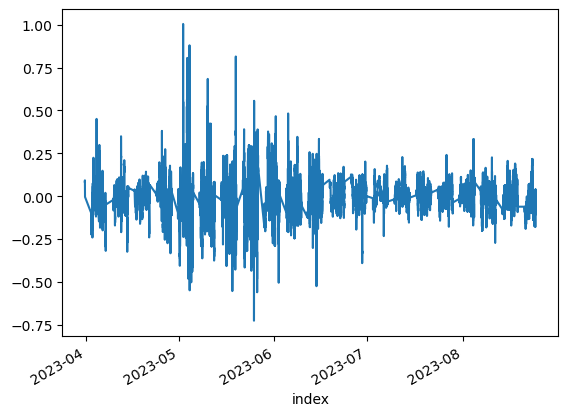

In [64]:
df['zp_data'].plot()

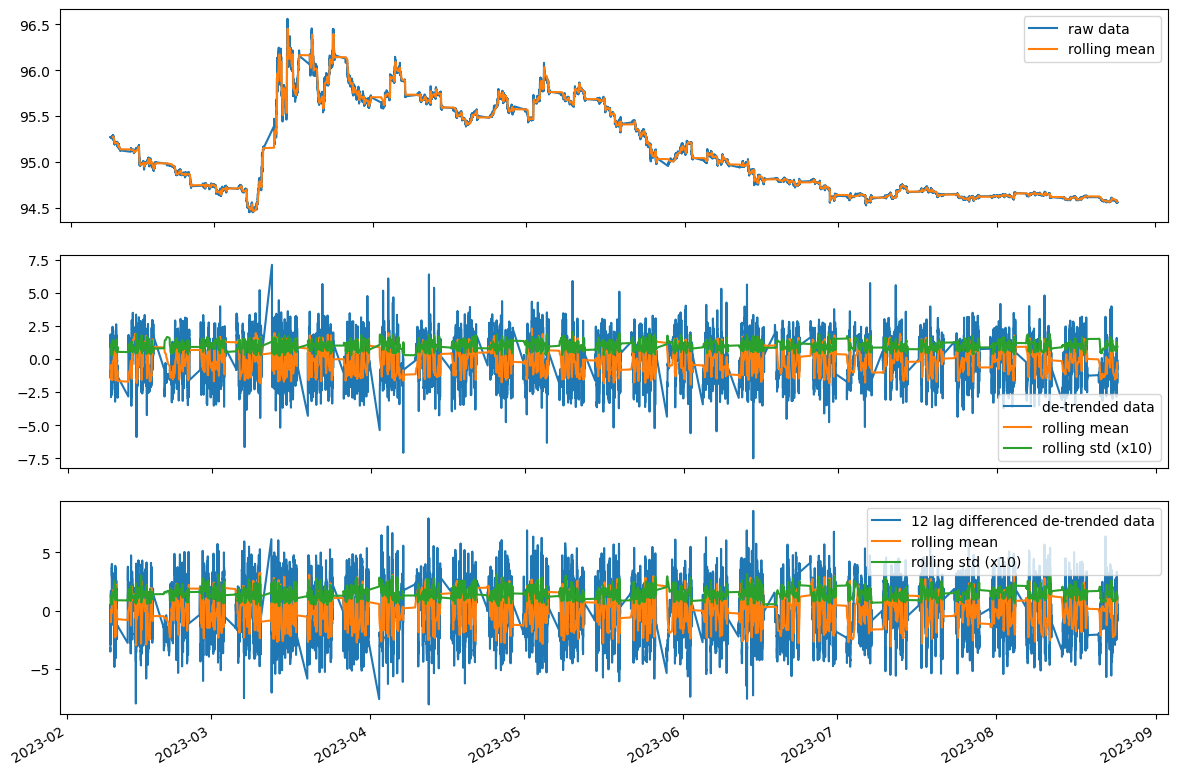

In [36]:
df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=60).mean()) / df['close'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)


def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['close'], label='raw data')
    ax[0].plot(df['close'].rolling(window=60).mean(), label="rolling mean");
    #ax[0].plot(df['open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_close'], label="de-trended data")
    ax[1].plot(df['z_close'].rolling(window=60).mean(), label="rolling mean");
    ax[1].plot(df['z_close'].rolling(window=60).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df['zp_data'], label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_data'].rolling(window=60).mean(), label="rolling mean");
    ax[2].plot(df['zp_data'].rolling(window=60).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df)

In [22]:
from sklearn import preprocessing
df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=60).mean()) / df['close'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)
df.dropna(inplace = True)
standard = preprocessing.scale(df['zp_data'].dropna())
zp_data_std =df['zp_data'].std() 
df['zp_data_standard'] = standard

In [18]:
# standardization of dependent variables
from sklearn import preprocessing

standard = preprocessing.scale(df['zp_data'].dropna())
standard

array([-1.65922123, -1.79340622, -1.22872166, ...,  0.2922895 ,
       -0.45352925, -0.08084567])

In [25]:
df['zp_data'].std()

1.9572852710860993

In [233]:
df#['zp_data'].plot()

,close,z_close,zp_data
index,,,
2023-02-07 18:40:00,95.250,NaN,NaN
2023-02-07 19:27:00,95.265,NaN,NaN
2023-02-07 19:56:00,95.270,NaN,NaN
2023-02-07 20:14:00,95.275,NaN,NaN
2023-02-07 20:19:00,95.275,NaN,NaN
...,...,...,...
2023-08-23 15:23:00,94.595,-0.725081,-1.457749
2023-08-23 15:26:00,94.595,-0.703346,-1.411203
2023-08-23 15:31:00,94.595,-0.681991,-1.363635


In [212]:
def rolling_z_score(df, lookback_mu, lookback_sigma):
    mu = df.rolling(lookback_mu).mean()
    sigma = df.rolling(lookback_sigma).std()
    df['indicator'] = (df.copy() - mu) / sigma
    return df


def signal_rolling_z_meanreversion(df,lookback_mu, lookback_sigma, bound):
    
    signals=pd.DataFrame(rolling_z_score(df,lookback_mu, lookback_sigma))
    signals['positions']=0

    #increase position size relative to strength of indicator pass the 
    signals.loc[signals["indicator"] <= -bound , "positions"] = -signals["indicator"]-bound
    signals.loc[signals["indicator"] >= bound , "positions"] = -signals["indicator"]+bound
    #sizing determined by tanh function to set between -1 and 1, this stops us from overbetting/ setting bets with concurrent signals >1
    #signals["signals"]=np.tanh(signals["positions"])

    return signals

df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=60).mean()) / df['close'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)

signal_df = signal_rolling_z_meanreversion(volume_trades[['close']], 600,600,2)

C:\Users\chengc3\AppData\Local\Temp\ipykernel_18924\2459001072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['indicator'] = (df.copy() - mu) / sigma


In [228]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt # For debug only


def genhurst(z):
# =============================================================================
# calculation of Hurst exponent given log price series z
# =============================================================================
    z=pd.DataFrame(z)
    z = np.log(z)
    taus=np.arange(np.round(len(z)/10)).astype(int) # We cannot use tau that is of same magnitude of time series length 
    logVar=np.empty(len(taus)) # log variance

    for tau in taus:
        logVar[tau]=np.log(z.diff(tau).var(ddof=0))
        
    X=np.log(taus)    
    Y=logVar[:len(taus)]
    X=X[np.isfinite(logVar)]
    Y=Y[np.isfinite(logVar)]
#    pd.DataFrame(np.asmatrix([X, Y]).T).to_csv('XY.csv')

    X = sm.add_constant(X)
#    plt.scatter(X[:,1], Y) # for debug only
    model=sm.OLS(Y, X)
    results=model.fit()
    H=results.params[1]/2
    pVal=results.pvalues[1]
    return H, pVal
genhurst(df['zp_data'] )

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_18924\2446973839.py:19: RuntimeWarning: divide by zero encountered in log
  X=np.log(taus)


(0.004870257404059433, 1.340673189207167e-32)

In [11]:
df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=60).mean()) / df['close'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)
df['zp_data_scaled'] = df['zp_data']


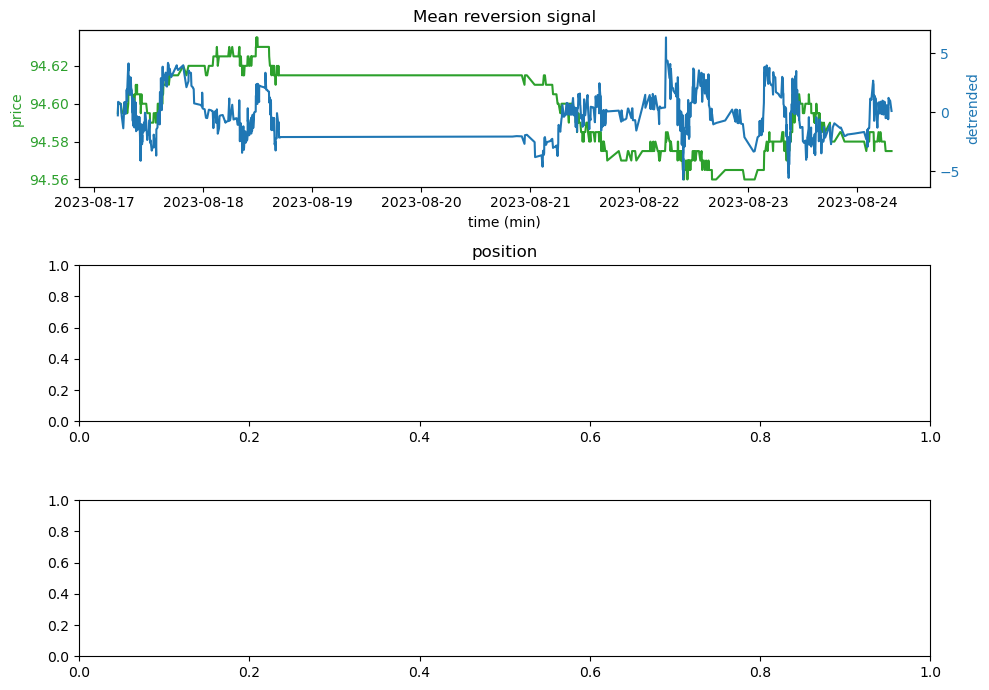

In [8]:
df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=60).mean()) / df['close'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)
df['zp_data_scaled'] = df['zp_data']


fig = plt.figure(figsize=(10, 7))
fig.add_subplot(311)   #first is number of rows, second is number of columns
fig.add_subplot(312)   
fig.add_subplot(313)   
# create all axes we need
ax0 = plt.subplot(311) #first is number of rows, second is number of columns
ax1 = ax0.twinx()
ax2 = plt.subplot(312)
#ax3 = ax2.twinx()
ax1.set_title('Mean reversion signal')
ax2.set_title('position')
#signal plot
color = 'tab:green'
ax0.set_xlabel('time (min)')
ax0.set_ylabel('price', color=color)
ax0.plot(df['close'].tail(1000).index, df['close'].tail(1000), color=color)
ax0.tick_params(axis='y', labelcolor=color)

ax4 = plt.subplot(313)
#price plot
color = 'tab:blue'
ax1.set_ylabel('detrended', color=color)  # we already handled the x-label with ax1
ax1.plot(df['zp_data'].tail(1000).index, df['zp_data'].tail(1000), color=color)
ax1.tick_params(axis='y', labelcolor=color)

#signal plot
#ax2.plot(pos.index, pos[0], color=color)
#ax2.set_xlabel('time (min)')
#ax2.set_ylabel('positions triggered')
# share the secondary axes
#ax3.get_shared_x_axes().join(ax1, ax3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

<AxesSubplot:xlabel='index'>

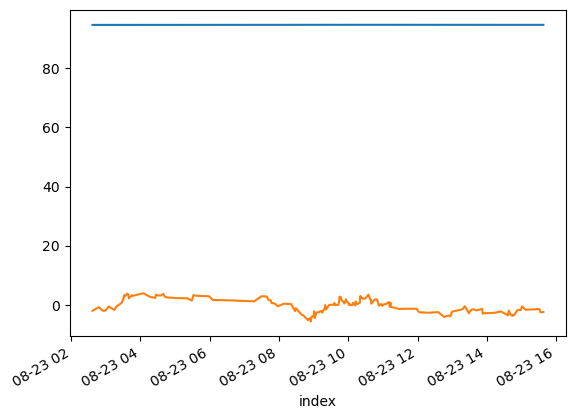

In [234]:
df['close'].tail(200).plot()
df['zp_data'].tail(200).plot()

In [177]:
df[["close"]].pct_change()


,close
index,
2023-02-07 18:48:00,NaN
2023-02-07 18:49:00,0.002190
2023-02-07 18:50:00,0.000647
2023-02-07 18:51:00,-0.000162
2023-02-07 18:52:00,0.001658
...,...
2023-08-23 14:32:00,0.001601
2023-08-23 14:33:00,0.001598
2023-08-23 14:34:00,-0.000745


<AxesSubplot:xlabel='index'>

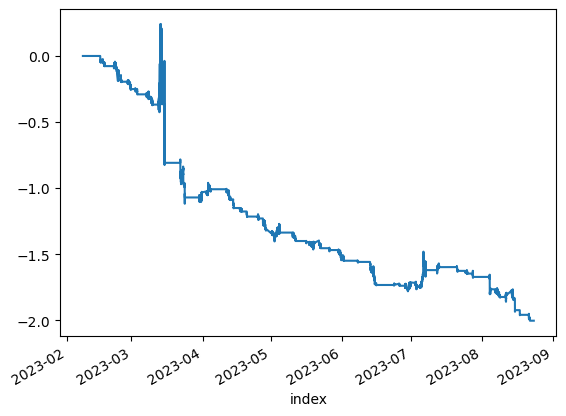

In [188]:
pnl.cumsum().plot()

<AxesSubplot:xlabel='index'>

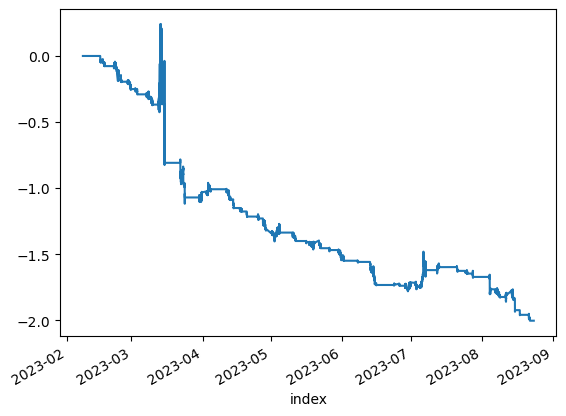

In [189]:
ret.cumsum().plot()

In [99]:
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['mean_return'] = mean_return_list
#df_results.to_csv('backtest_momo_intra_v4.csv')

3755

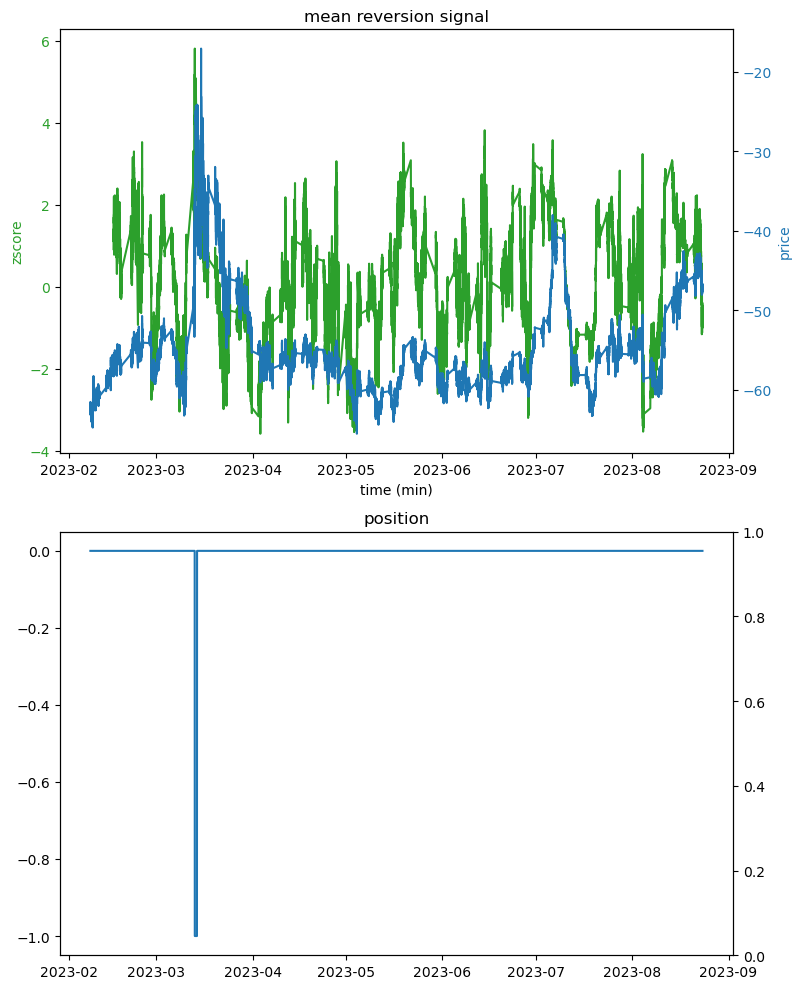

In [155]:
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(221)   #top left
#fig.add_subplot(222)   #top right
fig.add_subplot(223)   #bottom left
#fig.add_subplot(224)   #bottom right 
# create all axes we need
ax0 = plt.subplot(221)
ax1 = ax0.twinx()
ax2 = plt.subplot(223)
ax3 = ax2.twinx()
ax1.set_title('mean reversion signal')
ax2.set_title('position')
#signal plot
color = 'tab:green'
ax0.set_xlabel('time (min)')
ax0.set_ylabel('zscore', color=color)
ax0.plot(df['indicator'].index, df['indicator'], color=color)
ax0.tick_params(axis='y', labelcolor=color)

#price plot
color = 'tab:blue'
ax1.set_ylabel('price', color=color)  # we already handled the x-label with ax1
ax1.plot(df['close'].index, df['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

#signal plot
ax2.plot(pos.index, pos[0], color=color)

# share the secondary axes
ax3.get_shared_x_axes().join(ax1, ax3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

<AxesSubplot:xlabel='index'>

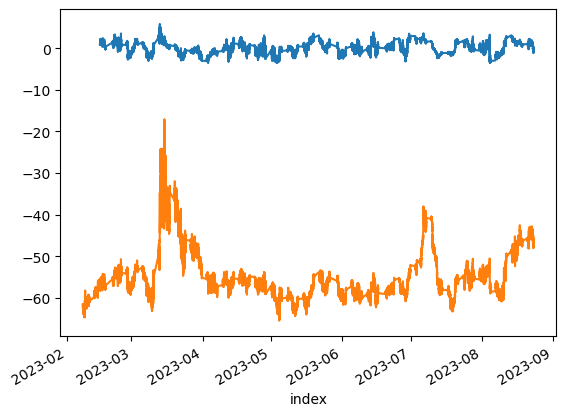

In [134]:
df['indicator'].plot()
df['close'].plot()

<AxesSubplot:xlabel='index'>

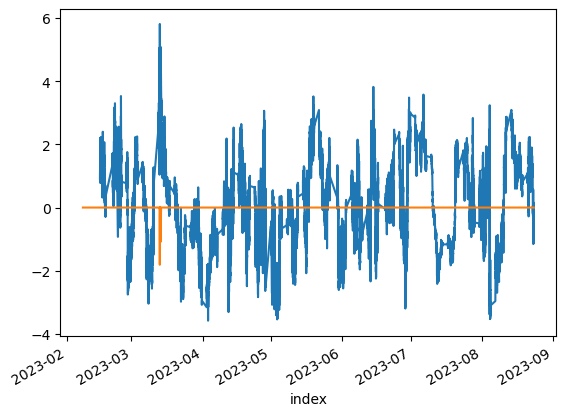

In [144]:
df['indicator'].plot()
df['positions'].plot()

<AxesSubplot:xlabel='index'>

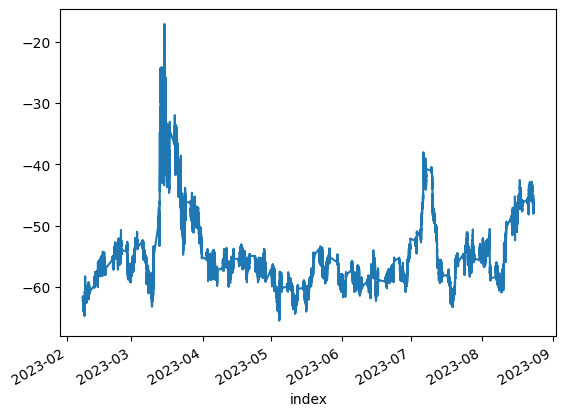

In [118]:
volume_trades['close'].plot()

<AxesSubplot:xlabel='index'>

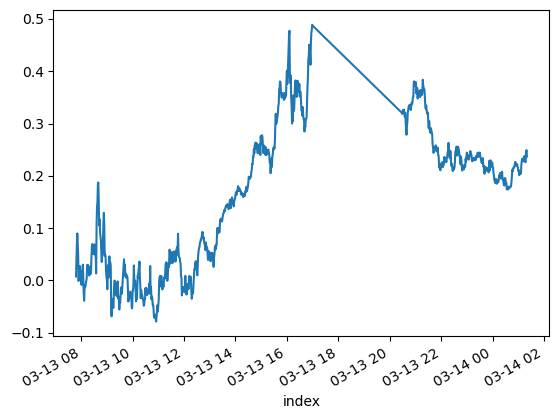

In [161]:
ret.cumsum().plot()#.plot()#[long_lag.index]

<AxesSubplot:xlabel='index'>

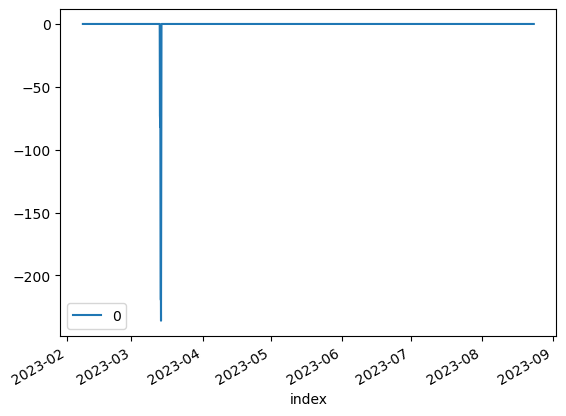

In [164]:
pos.plot()

In [77]:
for h in range(holdtime-1):
    # signal can double down

    long_lag=longs.copy().shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 

    short_lag=shorts.copy().shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [518]:
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['mean_return'] = mean_return_list
df_results.to_csv('backtest_momo_intra_480.csv')

In [475]:
for ma_tuples in short_long_tuples_list:
    #generate the crossover signal
    start_time = time.time()
    print(ma_tuples)
    df = volume_trades[['close']].copy()
    df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
    df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
    df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
    
    #criteria for position to be entered
    for ratio in ratio_entry_list:
        longs= df[['ewm_ratio']] > (1+ ratio)
        shorts=df[['ewm_ratio']] < (1-ratio)
        print("ratio_"+str(ratio))
        print("longslens_"+str(len(longs)))
        print("longsshorts_"+str(len(shorts)))

(30, 60)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 120)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 120)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 120)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 180)
ratio_0.000

ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
lon

ratio_0.0005
longslens_44902
longsshorts_44902
(240, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
lon

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 720)
ratio_0.0001
lon

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 840)
ratio_0.0001
lon

ratio_0.0005
longslens_44902
longsshorts_44902
(300, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
lon

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 1080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 1080)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(240, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 1320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 1320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1320)
ratio_0.0001

ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 1560)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 1560)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 1560)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 1560)
ratio_0.0001
lo

ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 1740)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 1740)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 1740)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 1740)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 1860)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 1860)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 1860)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 1860)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1980)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1980)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 1980)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 1980)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 2100)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 2100)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 2100)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 2100)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 2220)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 2220)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 2220)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 2220)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 2340)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 2340)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 2340)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 2340)
ratio_0.0001
l

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 2400)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 2400)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 2400)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 2460)
ratio_0.0001


ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 2640)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 2640)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 2640)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 2640)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(240, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 2940)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 3000)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 3000)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 3000)
ratio_0.0001
lo

ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 3180)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 3180)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(510, 3180)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 3180)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 3300)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 3300)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 3300)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 3300)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 3420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 3420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 3420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 3420)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 3540)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 3540)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 3540)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 3540)
ratio_0.0001
l

ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 3600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 3660)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 3660)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 3660)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
lo

ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 3720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 3720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 3720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 3780)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002


ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 3840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 3840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 3840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 3840)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 3960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 3960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 3960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 3960)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(420, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(510, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 4200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 4200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 4200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 4200)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(210, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

In [362]:
len(short_lag[short_lag['ewm_ratio']==True])

3

In [378]:
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
#df_results.to_csv('intra_ma_momo.csv')
df_results

,short_long_ma,holdtime_mins,ratio,apr,sharpe,max_dd,max_dd_ticks,max_dd_days,long_trades_no,short_trades_no
0,"(30, 60)",5,0.0001,0.000016,0.268158,0,0,0.0,114,96
1,"(30, 60)",10,0.0001,0.000016,0.268158,0,0,0.0,114,96
2,"(30, 60)",20,0.0001,0.000016,0.268158,0,0,0.0,114,96
3,"(30, 60)",30,0.0001,0.000016,0.268158,0,0,0.0,114,96
4,"(30, 60)",120,0.0001,0.000016,0.268158,0,0,0.0,114,96
5,"(30, 60)",5,0.0002,0.000008,0.627500,0,0,0.0,19,11
6,"(30, 60)",10,0.0002,0.000008,0.627500,0,0,0.0,19,11


60
APR=0.000700 Sharpe=0.733223
Max DD=-0.116913 Max DDD in days=4270
12976 15848


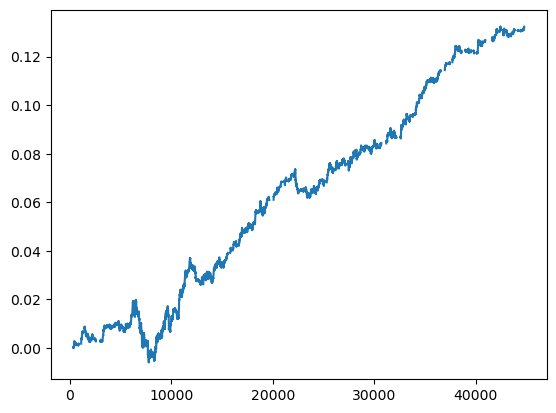

In [514]:
ma_tuples = (30,60)
holdtime=60

ratio = 0.0001

start_time 
df = volume_trades[['close']].copy()

print(holdtime)
df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
df['ewm_ratio'] = df['ewm_short']/df['ewm_long']

        
longs= df[['ewm_ratio']] > (1+ ratio)
shorts=df[['ewm_ratio']] < (1-ratio)

pos=np.zeros(df[['close']].shape)

for h in range(holdtime-1): # this prevents doubling down of signal 
    #(but will keep extending 1 bar if the signal remains strong) so no hard take profit!
    #moving stop loss ?
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()#marker='x')

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
print(len(pos[pos[0]>0]),len(pos[pos[0]<0]))

<AxesSubplot:xlabel='index'>

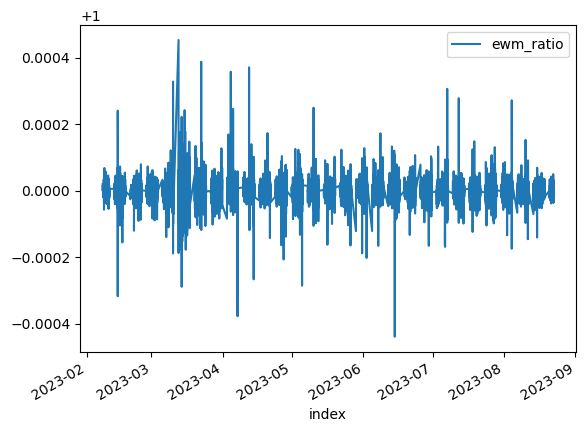

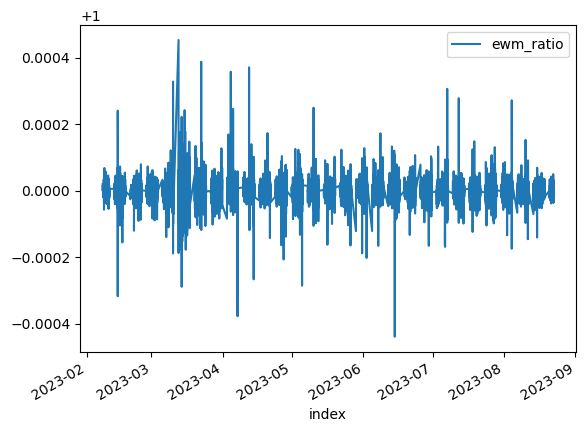

In [500]:
df[['ewm_ratio']].plot()

df_second[['ewm_ratio']].plot()

In [510]:
df[['ewm_long']]#.to_csv('ewm_')

,ewm_long
index,
2023-02-07 19:20:00,96.745000
2023-02-07 19:53:00,96.745000
2023-02-07 20:39:00,96.748445
2023-02-07 21:29:00,96.750167
2023-02-07 21:58:00,96.753334
...,...
2023-08-23 09:49:00,95.718208
2023-08-23 09:50:00,95.719906
2023-08-23 09:51:00,95.721548


In [509]:
df_second[['ewm_long']]#.plot()

,ewm_long
index,
2023-02-07 19:20:00,96.745000
2023-02-07 19:53:00,96.745000
2023-02-07 20:39:00,96.748370
2023-02-07 21:29:00,96.750056
2023-02-07 21:58:00,96.753111
...,...
2023-08-23 09:49:00,95.693301
2023-08-23 09:50:00,95.694148
2023-08-23 09:51:00,95.694986


<AxesSubplot:xlabel='index'>

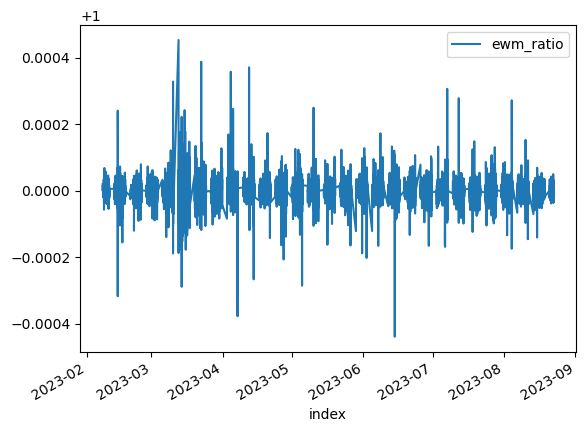

In [495]:
df[['ewm_ratio']].plot()

60
APR=0.000358 Sharpe=1.133711
Max DD=-0.063326 Max DDD in days=5443
3158 2655


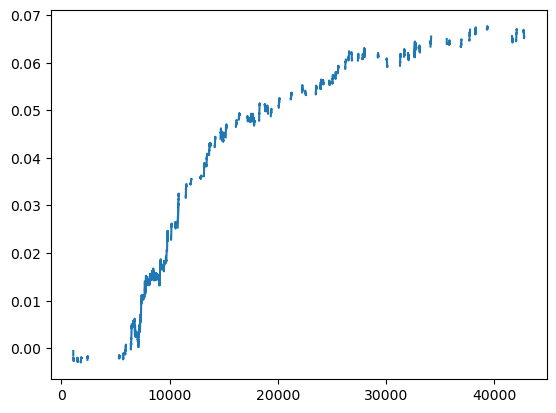

In [498]:
ma_tuples = (30,60)
holdtime=60

ratio = 0.0001

start_time 
df = volume_trades[['close']].copy()

print(holdtime)
df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
df_second = df.copy()
        
longs= df[['ewm_ratio']] > (1+ ratio)
shorts=df[['ewm_ratio']] < (1-ratio)

pos=np.zeros(df[['close']].shape)

for h in range(holdtime-1): # this prevents doubling down of signal 
    #(but will keep extending 1 bar if the signal remains strong) so no hard take profit!
    #moving stop loss ?
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()#marker='x')

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
print(len(pos[pos[0]>0]),len(pos[pos[0]<0]))

In [483]:
pos[pos[0]<0]

,0
1097,-1.0
1098,-1.0
1159,-1.0
1160,-1.0
1161,-1.0
...,...
42742,-1.0
42743,-1.0
42744,-1.0
42745,-1.0


In [384]:
#FOR TY FUTURES
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
cc_results = []
pval_results =[]
lookback_list = []
holdtime_list = []
time_space_list =[]
ratio_entry_list = []
long_time_space_list = []
short_long_tuples_list = []
trade_long_list = []
trade_short_list =[]

#results lists
results_tuple_list = []
results_hold_list = []
results_ratio_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
#lookback periods for MA
#lookback short MA
for p in range(30,721,30):
    time_space_list.append(p)    
#lookback long MA
for p in range(60,24*60*3+1,60):
    long_time_space_list.append(p)   
#create tuples of lookback long MA and short MA
for i in long_time_space_list:
    for j in time_space_list:
        if j< i:
            short_long_tuples_list.append((j,i))
#entry criteria for short MA/long MA ratio:

for p in range(1,6,1):
    #1.0005
    ratio_entry_list.append(p/10000)
    
#different holdtimes
for p in range(60,601,60):
    holdtime_list.append(p)    
holdtime_list = [5,10,20,30,120]    
#so we can have exits based off holdtime
#or based off hitting upper bounds(?) of the short/long entries
    
#try first for holdtime

#short_long_tuples_list =[(60,720),(90,720)]
#holdtime_list = [360]
for ma_tuples in short_long_tuples_list:
    #generate the crossover signal
    start_time = time.time()
    print(ma_tuples)
    df = volume_trades[['close']].copy()
    df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
    df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
    df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
    
    #criteria for position to be entered
    for ratio in ratio_entry_list:
        print(ratio)
        longs= df[['ewm_ratio']] > (1+ ratio)
        shorts=df[['ewm_ratio']] < (1-ratio)

        pos=np.zeros(df[['close']].shape)
        for holdtime in holdtime_list:
        #pnl based off holdtime
            print(holdtime)
        #holddays=ma_tuples[1]
            for h in range(holdtime-1): # signal can double down (look into how we can change this)
                
                long_lag=longs.shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 
                short_lag=shorts.shift(h).fillna(False)
                pos[long_lag]=pos[long_lag]+1
                pos[short_lag]=pos[short_lag]-1

            pos=pd.DataFrame(pos, index = longs.index)

            pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
            ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
            cumret=(np.cumprod(1+ret)-1)
            print("---returns data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
            print("---sharpe data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            #print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
            if sharpe> 1:
                maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
            else:
                maxDD = 0
                maxDDD = 0
            print("---maxdd data %s seconds ---" % (time.time() - start_time))
            #print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
            results_tuple_list.append(ma_tuples)
            results_hold_list.append(holdtime)
            results_ratio_trigger_list.append(ratio)
            apr_list.append(np.prod(1+ret)**(252/len(ret))-1)
            sharpe_list.append( sharpe)
            dd_list.append(maxDD)
            dd_time_list.append(maxDDD)
            trade_long_list.append(len(long_lag[long_lag['ewm_ratio']==True]))
            trade_short_list.append(len(short_lag[short_lag['ewm_ratio']==True]))
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list

(30, 60)
0.0001
5
0
0
---returns data 0.21140480041503906 seconds ---
---sharpe data 0.0 seconds ---
---maxdd data 0.0 seconds ---
10
0
0
---returns data 3.466886520385742 seconds ---
---sharpe data 0.0 seconds ---
---maxdd data 0.0 seconds ---
20


KeyboardInterrupt: 

In [397]:
long_lag[long_lag['ewm_ratio']==True]

,ewm_ratio
index,
2023-02-07 12:53:00,True
2023-02-14 08:39:00,True
2023-02-14 08:40:00,True
2023-03-09 08:37:00,True
2023-03-10 08:37:00,True
...,...
2023-07-19 02:10:00,True
2023-07-26 14:42:00,True
2023-07-27 23:41:00,True


In [417]:
longs#[longs['ewm_ratio']==True]

,ewm_ratio
index,
2023-02-06 18:36:00,False
2023-02-06 19:05:00,False
2023-02-06 19:11:00,False
2023-02-06 19:13:00,False
2023-02-06 19:18:00,False
...,...
2023-08-22 11:50:00,False
2023-08-22 11:52:00,False
2023-08-22 11:53:00,False


In [390]:
pos[long_lag]+1

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
44897,NaN
44898,NaN
44899,NaN
44900,NaN


In [468]:
#FOR TY FUTURES
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
cc_results = []
pval_results =[]
lookback_list = []
holdtime_list = []
time_space_list =[]
ratio_entry_list = []
long_time_space_list = []
short_long_tuples_list = []
trade_long_list = []
trade_short_list =[]

#results lists
results_tuple_list = []
results_hold_list = []
results_ratio_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
#lookback periods for MA
#lookback short MA
for p in range(30,721,30):
    time_space_list.append(p)    
#lookback long MA
for p in range(60,24*60*3+1,60):
    long_time_space_list.append(p)   
#create tuples of lookback long MA and short MA
for i in long_time_space_list:
    for j in time_space_list:
        if j< i:
            short_long_tuples_list.append((j,i))
#entry criteria for short MA/long MA ratio:

for p in range(1,6,1):
    #1.0005
    ratio_entry_list.append(p/10000)
    
#different holdtimes
for p in range(60,601,60):
    holdtime_list.append(p)    
    
    

#so we can have exits based off holdtime
#or based off hitting upper bounds(?) of the short/long entries
    
#try first for holdtime

short_long_tuples_list =[(60,720)]
holdtime_list = [20]
ratio_entry_list = [0.0002]
for ma_tuples in short_long_tuples_list:
    #generate the crossover signal
    start_time = time.time()
    print(ma_tuples)
    df = volume_trades[['close']].copy()
    df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
    df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
    df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
    
    #criteria for position to be entered
    for ratio in ratio_entry_list:
        print(ratio)
        longs= df[['ewm_ratio']] > (1+ ratio)
        shorts=df[['ewm_ratio']] < (1-ratio)

        
        for holdtime in holdtime_list:
            pos=np.zeros(df[['close']].shape)
        #pnl based off holdtime
            print(holdtime)
            for h in range(holdtime-1):
                # signal can double down (look into how we can change this)
                
                long_lag=longs.copy().shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 
                
                short_lag=shorts.copy().shift(h).fillna(False)
                pos[long_lag]=pos[long_lag]+1
                pos[short_lag]=pos[short_lag]-1

            pos=pd.DataFrame(pos, index = longs.index)

            pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
            ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
            print(np.mean(ret))
            print(np.std(ret))
            cumret=(np.cumprod(1+ret)-1)
            print("---returns data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
            print("---sharpe data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))

            maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
            print("---maxdd data %s seconds ---" % (time.time() - start_time))
            print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
            results_tuple_list.append(ma_tuples)
            results_hold_list.append(holdtime)
            results_ratio_trigger_list.append(ratio)
            apr_list.append(np.prod(1+ret)**(252/len(ret))-1)
            sharpe_list.append( sharpe)
            dd_list.append(maxDD)
            dd_time_list.append(maxDDD)
            trade_long_list.append(len(long_lag[long_lag['ewm_ratio']==True]))
            trade_short_list.append(len(short_lag[short_lag['ewm_ratio']==True]))

(60, 720)
0.0002
20
-9.520909718683309e-06
0.0002466818696183178
---returns data 0.2922170162200928 seconds ---
---sharpe data 0.0 seconds ---
APR=-0.000021 Sharpe=-0.612691
---maxdd data 0.3156905174255371 seconds ---
Max DD=-0.007415 Max DDD in days=23


In [469]:
shorts.to_csv('shorts.csv')#[shorts['ewm_ratio']== True].head(30)
longs.to_csv('longs.csv')
pos.to_csv('POSITIONs.csv')

In [452]:
pos.to_csv('POSITIONs.csv')

In [426]:
pos[short_lag]

array([ 1., -3., -2., -1., -1., -2., -1., -1., -1., -1., -1.])

<AxesSubplot:xlabel='index'>

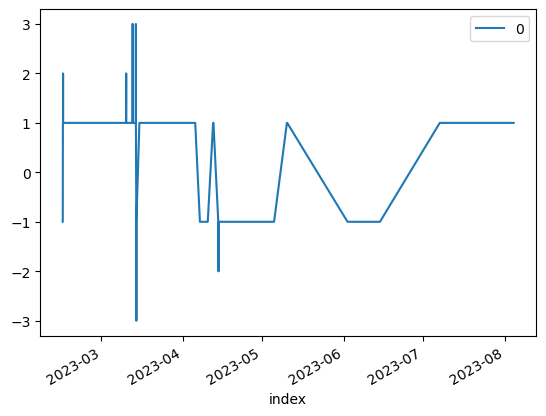

In [427]:
pos=pd.DataFrame(pos, index = longs.index)
pos[pos[0]!=0].plot()

In [74]:
pos=pd.DataFrame(pos)

pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
print("---returns data %s seconds ---" % (time.time() - start_time))
start_time = time.time()
sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
print("---sharpe data %s seconds ---" % (time.time() - start_time))
start_time = time.time()

NameError: name 'signal_returns' is not defined

In [70]:
for ticker_ts in tickers:

    #Let's set horizons for holding positions and oscciated returns  
    #This will allow us to see the historic returns using the signal without explicit profit targets
    #From here we can set expectations of profit targets when we do use the signal caveat based off historical values

    horizons = np.linspace(1, 180, 180,dtype = int)#[1,2,3,4,5,10,20]
    #pnl_raw=df[[ticker_ts]].copy().dropna() # to be consumed into the pnl_df
    pnl_raw=df.copy().dropna()
    pnl_df =pd.DataFrame(index =pnl_raw.index )
    #STOP LOSS STEP 1 define dataframe ####################################
    stoploss_df = df.copy()
    
    for horizon in horizons:
        horizon = int(horizon)
        pnl_df["returns_"] = -pnl_raw.diff(-horizon)#.diff(horizon)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [34]:
df['date']=df.index.strftime("%m/%d/%Y")

In [60]:
df

,open,high,low,close,volume,num_trds,value,ticker,date,time
2023-01-30 18:03:00-05:00,9692.0,9692.0,9692.0,9692.0,13,3,1259.960,SFRZ4 Comdty,01/30/2023,18:03:00
2023-01-30 18:04:00-05:00,9691.5,9691.5,9691.5,9691.5,4,3,387.660,SFRZ4 Comdty,01/30/2023,18:04:00
2023-01-30 18:05:00-05:00,9691.5,9691.5,9691.5,9691.5,1,1,96.915,SFRZ4 Comdty,01/30/2023,18:05:00
2023-01-30 18:17:00-05:00,9691.5,9691.5,9691.5,9691.5,2,1,193.830,SFRZ4 Comdty,01/30/2023,18:17:00
2023-01-30 18:22:00-05:00,9691.0,9691.0,9691.0,9691.0,4,1,387.640,SFRZ4 Comdty,01/30/2023,18:22:00
...,...,...,...,...,...,...,...,...,...,...
2023-08-15 14:14:00-04:00,9578.5,9578.5,9578.5,9578.5,82,10,7854.371,SFRZ4 Comdty,08/15/2023,14:14:00
2023-08-15 14:15:00-04:00,9578.5,9578.5,9578.5,9578.5,27,3,2586.195,SFRZ4 Comdty,08/15/2023,14:15:00
2023-08-15 14:16:00-04:00,9578.5,9578.5,9578.0,9578.0,334,23,31990.863,SFRZ4 Comdty,08/15/2023,14:16:00
2023-08-15 14:17:00-04:00,9578.0,9578.0,9578.0,9578.0,680,36,65130.395,SFRZ4 Comdty,08/15/2023,14:17:00


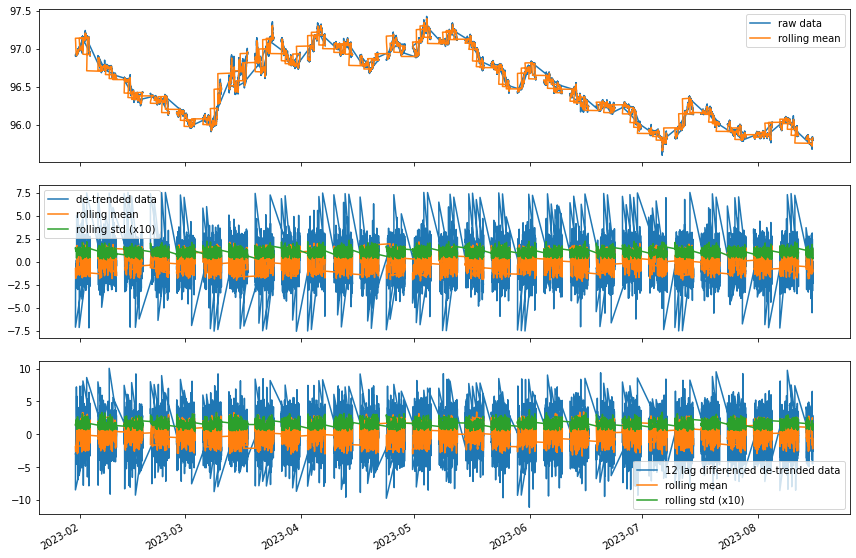

In [15]:

train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
#df['open'].plot(figsize=(12,3));
#plt.title(jobj[0]['title']);

df['z_open'] = (df['open'] - df['open'].rolling(window=60).mean()) / df['open'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_open'] - df['z_open'].shift(60)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['open'], label='raw data')
    ax[0].plot(df['open'].rolling(window=60).mean(), label="rolling mean");
    #ax[0].plot(df['open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_open'], label="de-trended data")
    ax[1].plot(df['z_open'].rolling(window=60).mean(), label="rolling mean");
    ax[1].plot(df['z_open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df['zp_data'], label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_data'].rolling(window=60).mean(), label="rolling mean");
    ax[2].plot(df['zp_data'].rolling(window=60).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df)

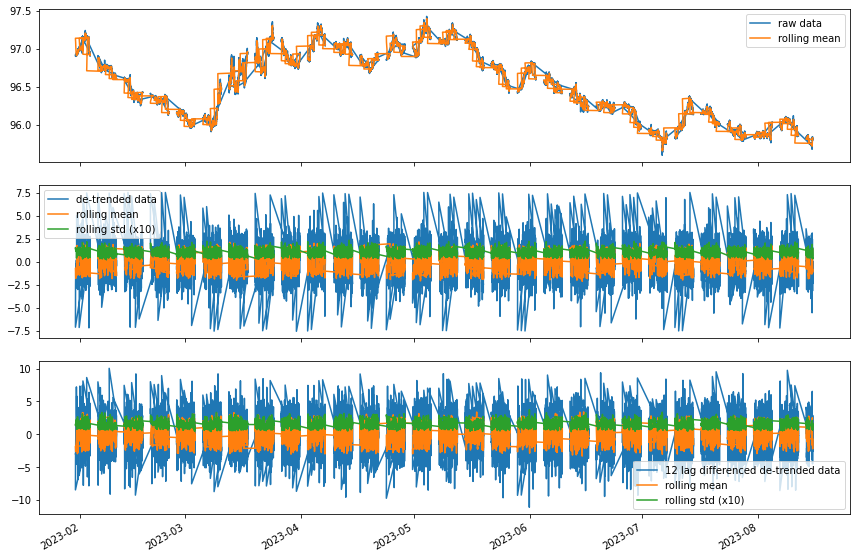

In [7]:
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
#df['open'].plot(figsize=(12,3));
#plt.title(jobj[0]['title']);

df['z_open'] = (df['open'] - df['open'].rolling(window=60).mean()) / df['open'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_open'] - df['z_open'].shift(60)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['open'], label='raw data')
    ax[0].plot(df['open'].rolling(window=60).mean(), label="rolling mean");
    #ax[0].plot(df['open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_open'], label="de-trended data")
    ax[1].plot(df['z_open'].rolling(window=60).mean(), label="rolling mean");
    ax[1].plot(df['z_open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df['zp_data'], label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_data'].rolling(window=60).mean(), label="rolling mean");
    ax[2].plot(df['zp_data'].rolling(window=60).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df)

In [135]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df['open'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.11f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df['z_open'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.11f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df['zp_data'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.11f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -0.904
P-value = 0.78674337434
Critical values :
	1%: -3.4310725400597795 - The data is not stationary with 99% confidence
	5%: -2.8618593160475885 - The data is not stationary with 95% confidence
	10%: -2.566939966893172 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -13.788
P-value = 0.00000000000
Critical values :
	1%: -3.4310748627134475 - The data is  stationary with 99% confidence
	5%: -2.8618603423853015 - The data is  stationary with 95% confidence
	10%: -2.5669405132181993 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -14.430
P-value = 0.00000000000
Critical values :
	1%: -3.4310823309791743 - The data is  stationary with 99% confidence
	5%: -2.8618636424684114 - The data is  stationary with 95% confidence
	10%: -2.56694226987094 - The data is  stationary with 90% confidence


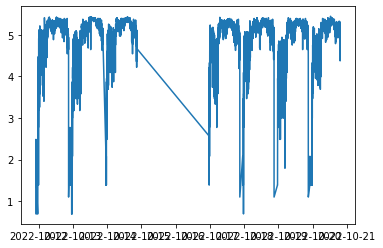

In [138]:
plot(np.log(df['open']))

<AxesSubplot:>

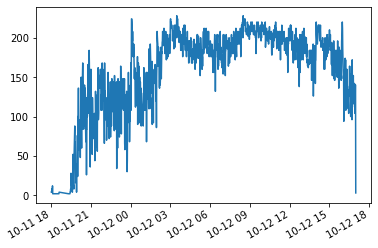

In [141]:
fut['num_trds'].plot()

In [142]:
fut

,open,high,low,close,volume,num_trds,value
2022-10-11 18:01:00-04:00,3.6778,3.6778,3.6770,3.6770,0,4,0.0
2022-10-11 18:02:00-04:00,3.6770,3.6770,3.6770,3.6770,0,4,0.0
2022-10-11 18:03:00-04:00,3.6770,3.6770,3.6770,3.6770,0,8,0.0
2022-10-11 18:04:00-04:00,3.6770,3.6770,3.6770,3.6770,0,4,0.0
2022-10-11 18:05:00-04:00,3.6770,3.6770,3.6770,3.6770,0,4,0.0
...,...,...,...,...,...,...,...
2022-10-12 16:56:00-04:00,3.6361,3.6373,3.6355,3.6372,0,138,0.0
2022-10-12 16:57:00-04:00,3.6371,3.6375,3.6362,3.6367,0,104,0.0
2022-10-12 16:58:00-04:00,3.6367,3.6367,3.6352,3.6358,0,140,0.0
2022-10-12 16:59:00-04:00,3.6358,3.6372,3.6355,3.6370,0,140,0.0


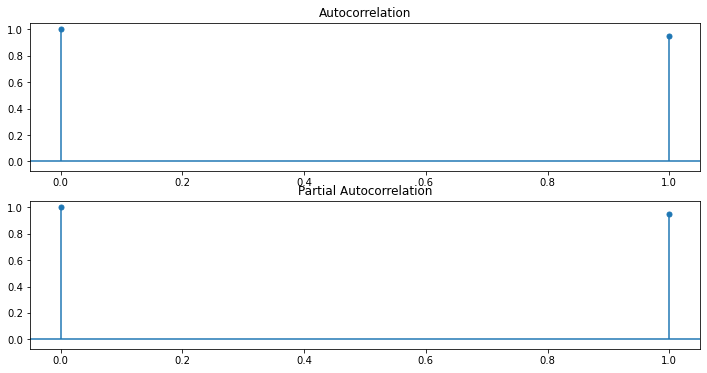

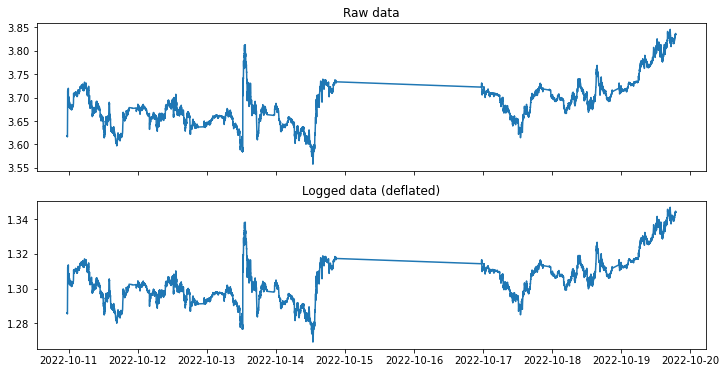

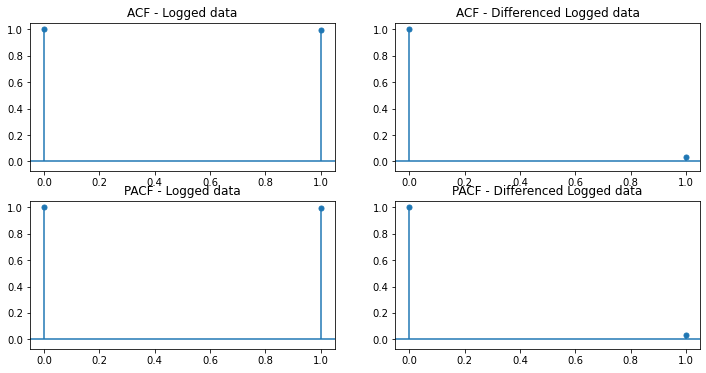

In [129]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
'''
“ — Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
— Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.”
'''


fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df['z_open'].dropna(), ax=ax[0], lags=1)
ax[1] = plot_pacf(df['z_open'].dropna(), ax=ax[1], lags=1)

#test 
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(df['open']);
ax[0].set_title("Raw data");
ax[1].plot(np.log(df['open']));
ax[1].set_title("Logged data (deflated)");
#ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(df['open'])- np.log(df['open']).shift()).dropna()
ax[0, 0] = plot_acf(np.log(df['open']), ax=ax[0, 0], lags=1, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(df['open']), ax=ax[1, 0], lags=1, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=1, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=1, title="PACF - Differenced Logged data")

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequ

                              ARMA Model Results                              
Dep. Variable:                   open   No. Observations:                 9050
Model:                     ARMA(0, 0)   Log Likelihood               26479.960
Method:                           css   S.D. of innovations              0.013
Date:                Wed, 19 Oct 2022   AIC                         -52955.921
Time:                        16:01:55   BIC                         -52941.700
Sample:                             0   HQIC                        -52951.083
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3047      0.000   9567.837      0.000       1.304       1.305
                             ARIMA Model Results                              
Dep. Variable:                 D.open   No. Observat

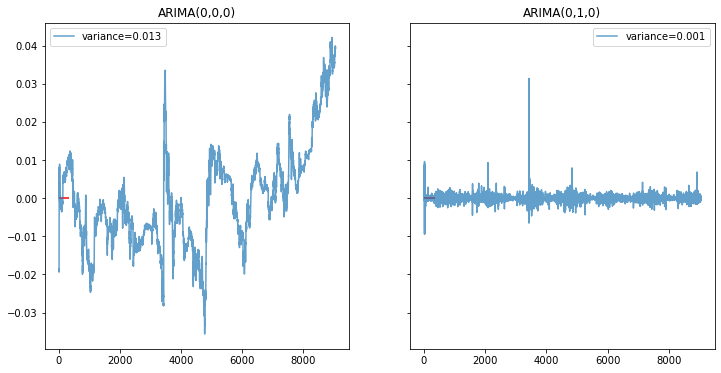

In [126]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df['open']).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df['open']).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequ

                             ARIMA Model Results                              
Dep. Variable:                 D.open   No. Observations:                 9049
Model:                 ARIMA(0, 1, 0)   Log Likelihood               51185.179
Method:                           css   S.D. of innovations              0.001
Date:                Wed, 19 Oct 2022   AIC                        -102366.357
Time:                        16:06:01   BIC                        -102352.136
Sample:                             1   HQIC                       -102361.519
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.437e-06   8.89e-06      0.724      0.469    -1.1e-05    2.39e-05
                             ARIMA Model Results                              
Dep. Variable:                 D.open   No. Observat

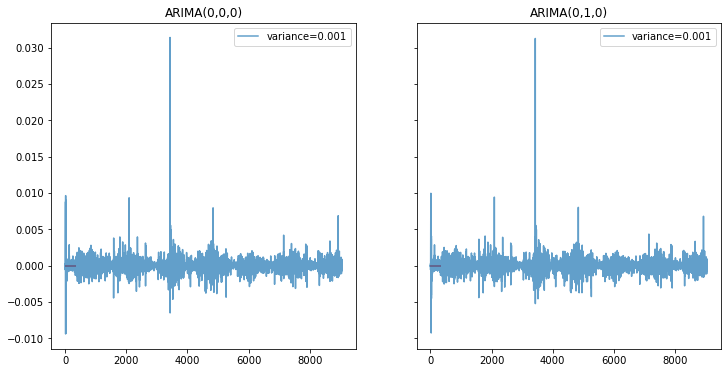

In [128]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df['open']).dropna(), (0, 1, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df['open']).dropna(), (2, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

In [132]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


ModuleNotFoundError: No module named 'pmdarima'

In [131]:
from platform import python_version
python_version() 

'3.8.8'